In [1]:
%matplotlib inline

import subprocess as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 300
from subs2vec.utensils import log_timer
from IPython.display import display, display_markdown

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

def convert_notebook(title, output='html'):
    convert = sp.run(f'jupyter nbconvert {title}.ipynb --to {output} --output {title}.{output}'.split(' '))
    if convert.returncode == 0:
        display_md(f'Jupyter notebook `{title}` converted successfully.')
    else:
        display_md(f'Error: encountered problem converting Jupyter notebook `{title}`')

def download(fname):
    dl = sp.run(f'wget {fname}'.split(' '))
    if dl.returncode == 0:
        display_md(f'Download of `{fname}` succesful.')
    else:
        display_md(f'Download of `{fname}` failed.')

sns.set(style='whitegrid', palette='Set2')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Identifying human-interpretable latent dimensions in word embeddings
## Background
Word embeddings are generally represented as vectors in a 300-dimensional space. These dimensions are the result of a neural network optimizing context prediction, and we therefore assume that they partition the variance in the distributional data somewhat efficiently. This does not necessarily mean that these dimensions are orthogonal (although that seems efficient and we will explore that possibility in section 1.2). It also does not mean that these dimensions are human-interpretable, however we do know from prior work (e.g. Van Paridon & Thompson, 2020) that simple linear transformations of these dimensions are sufficient for prediction many conceptual-semantic dimensions that _are_ human-interpretable and highly salient.

In this notebook we will explore whether we can uncover latent human-interpretable dimensions in word embeddings, using principal component analysis and factor analysis.

# Embeddings
We will use embeddings derived from two different corpora: OpenSubtitles and Common Crawl. These embeddings are not only derived from different corpora, but also trained using slightly different algorithms: The OpenSubtitles embeddings are trained using the fastText implementation of the skipgram algorithm, with subword information. The Common Crawl embeddings are trained using the fastText implementation of the bag-of-words algorithm, with subword information and position-weighted context vectors.  
To verify that results are at least somewhat generalizable, we will analyze embeddings in both English and Dutch (these languages are closely related, but the author is fluent in both and that happens to be convenient for these preliminary analyses).

In [2]:
# import module to handle word vectors
from subs2vec.vecs import Vectors

# load vectors
n = 1e4  # set number of word vectors to load
d = 300 # set dimensionality
subs_en = Vectors('subs.en.1e6.vec', normalize=True, n=n, d=d)  # English OpenSubtitles
subs_nl = Vectors('subs.nl.1e6.vec', normalize=True, n=n, d=d)  # Dutch OpenSubtitles
cc_en = Vectors('cc.en.300.vec', normalize=True, n=n, d=d)  # English Common Crawl
cc_nl = Vectors('cc.nl.300.vec', normalize=True, n=n, d=d)  # Dutch Common Crawl

[INFO] loading vectors subs.en.1e6.vec
[INFO] <function Vectors.__init__ at 0x129778268> ran in 0.762 seconds
[INFO] loading vectors subs.nl.1e6.vec
[INFO] <function Vectors.__init__ at 0x129778268> ran in 0.723 seconds
[INFO] loading vectors cc.en.300.vec
[INFO] <function Vectors.__init__ at 0x129778268> ran in 0.697 seconds
[INFO] loading vectors cc.nl.300.vec
[INFO] <function Vectors.__init__ at 0x129778268> ran in 0.692 seconds


## Correlations between embedding dimensions
For the purposes of these analyses, it is good to keep in mind that when it comes to embedding dimensions (or any other type of variable), uncorrelatedness is the same thing as orthogonality, and it implies linear independence (but not necessarily independence of any other kind). Conversely, dimensions that are correlated are not orthogonal or independent.

In [3]:
def correlations(vecs, d):
    corrs = vecs.as_df().corr()
    display(corrs.round(2))
    g = sns.heatmap(corrs, vmin=-1, vmax=1)
    corrs = corrs - np.eye(d)
    display(pd.DataFrame(corrs.values.ravel(), columns=['summary']).describe().round(2))
    return corrs

### English Common Crawl correlations

[INFO] <function Vectors.as_df at 0x129778048> ran in 0.029 seconds


0     1     2     3     4     5     6     7     8     9    ...   290  \
0    1.00  0.03 -0.01 -0.01  0.12 -0.03 -0.05  0.02  0.06  0.05  ...  0.01   
1    0.03  1.00 -0.03 -0.08  0.10  0.04 -0.09 -0.04  0.00 -0.02  ... -0.05   
2   -0.01 -0.03  1.00  0.08 -0.07 -0.02 -0.04  0.01 -0.00 -0.05  ...  0.15   
3   -0.01 -0.08  0.08  1.00 -0.14 -0.14  0.25 -0.03  0.03  0.02  ...  0.09   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
296  0.02 -0.00 -0.02 -0.03 -0.07 -0.02 -0.01  0.00  0.06 -0.05  ...  0.11   
297 -0.00 -0.06 -0.09 -0.17  0.13 -0.05 -0.04  0.06 -0.00  0.03  ... -0.23   
298 -0.11 -0.06  0.06  0.01 -0.10 -0.01  0.03  0.02  0.01 -0.01  ... -0.05   
299 -0.05  0.04  0.03  0.05  0.00 -0.11 -0.04 -0.03 -0.09 -0.01  ... -0.07   

      291   292   293   294   295   296   297   298   299  
0    0.01  0.00 -0.01 -0.02 -0.02  0.02 -0.00 -0.11 -0.05  
1   -0.03  0.17 -0.07 -0.02  0.03 -0.00 -0.06 -0.06  0.04  
2   -0.02 -0.02  0.03 -0.01 -0.01 -0.02 -0.09  0.06  0.03  
3   -0.03 -0.31  0.14 -0.00 -0.01 -0.03 -0.17  0.01  0.05  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
296  0.01 -0.01  0.01  0.02  0.02  1.00  0.02  0.02 -0.05  
297  0.03 -0.03 -0.05  0.01  0.03  0.02  1.00 -0.02 -0.04  
298  0.05 -0.03  0.02  0.05  0.00  0.02 -0.02  1.00  0.09  
299  0.01 -0.05  0.08 -0.04 -0.05 -0.05 -0.04  0.09  1.00  

[300 rows x 300 columns]

summary
count  90000.00
mean       0.00
std        0.06
min       -0.84
25%       -0.03
50%        0.00
75%        0.03
max        0.63

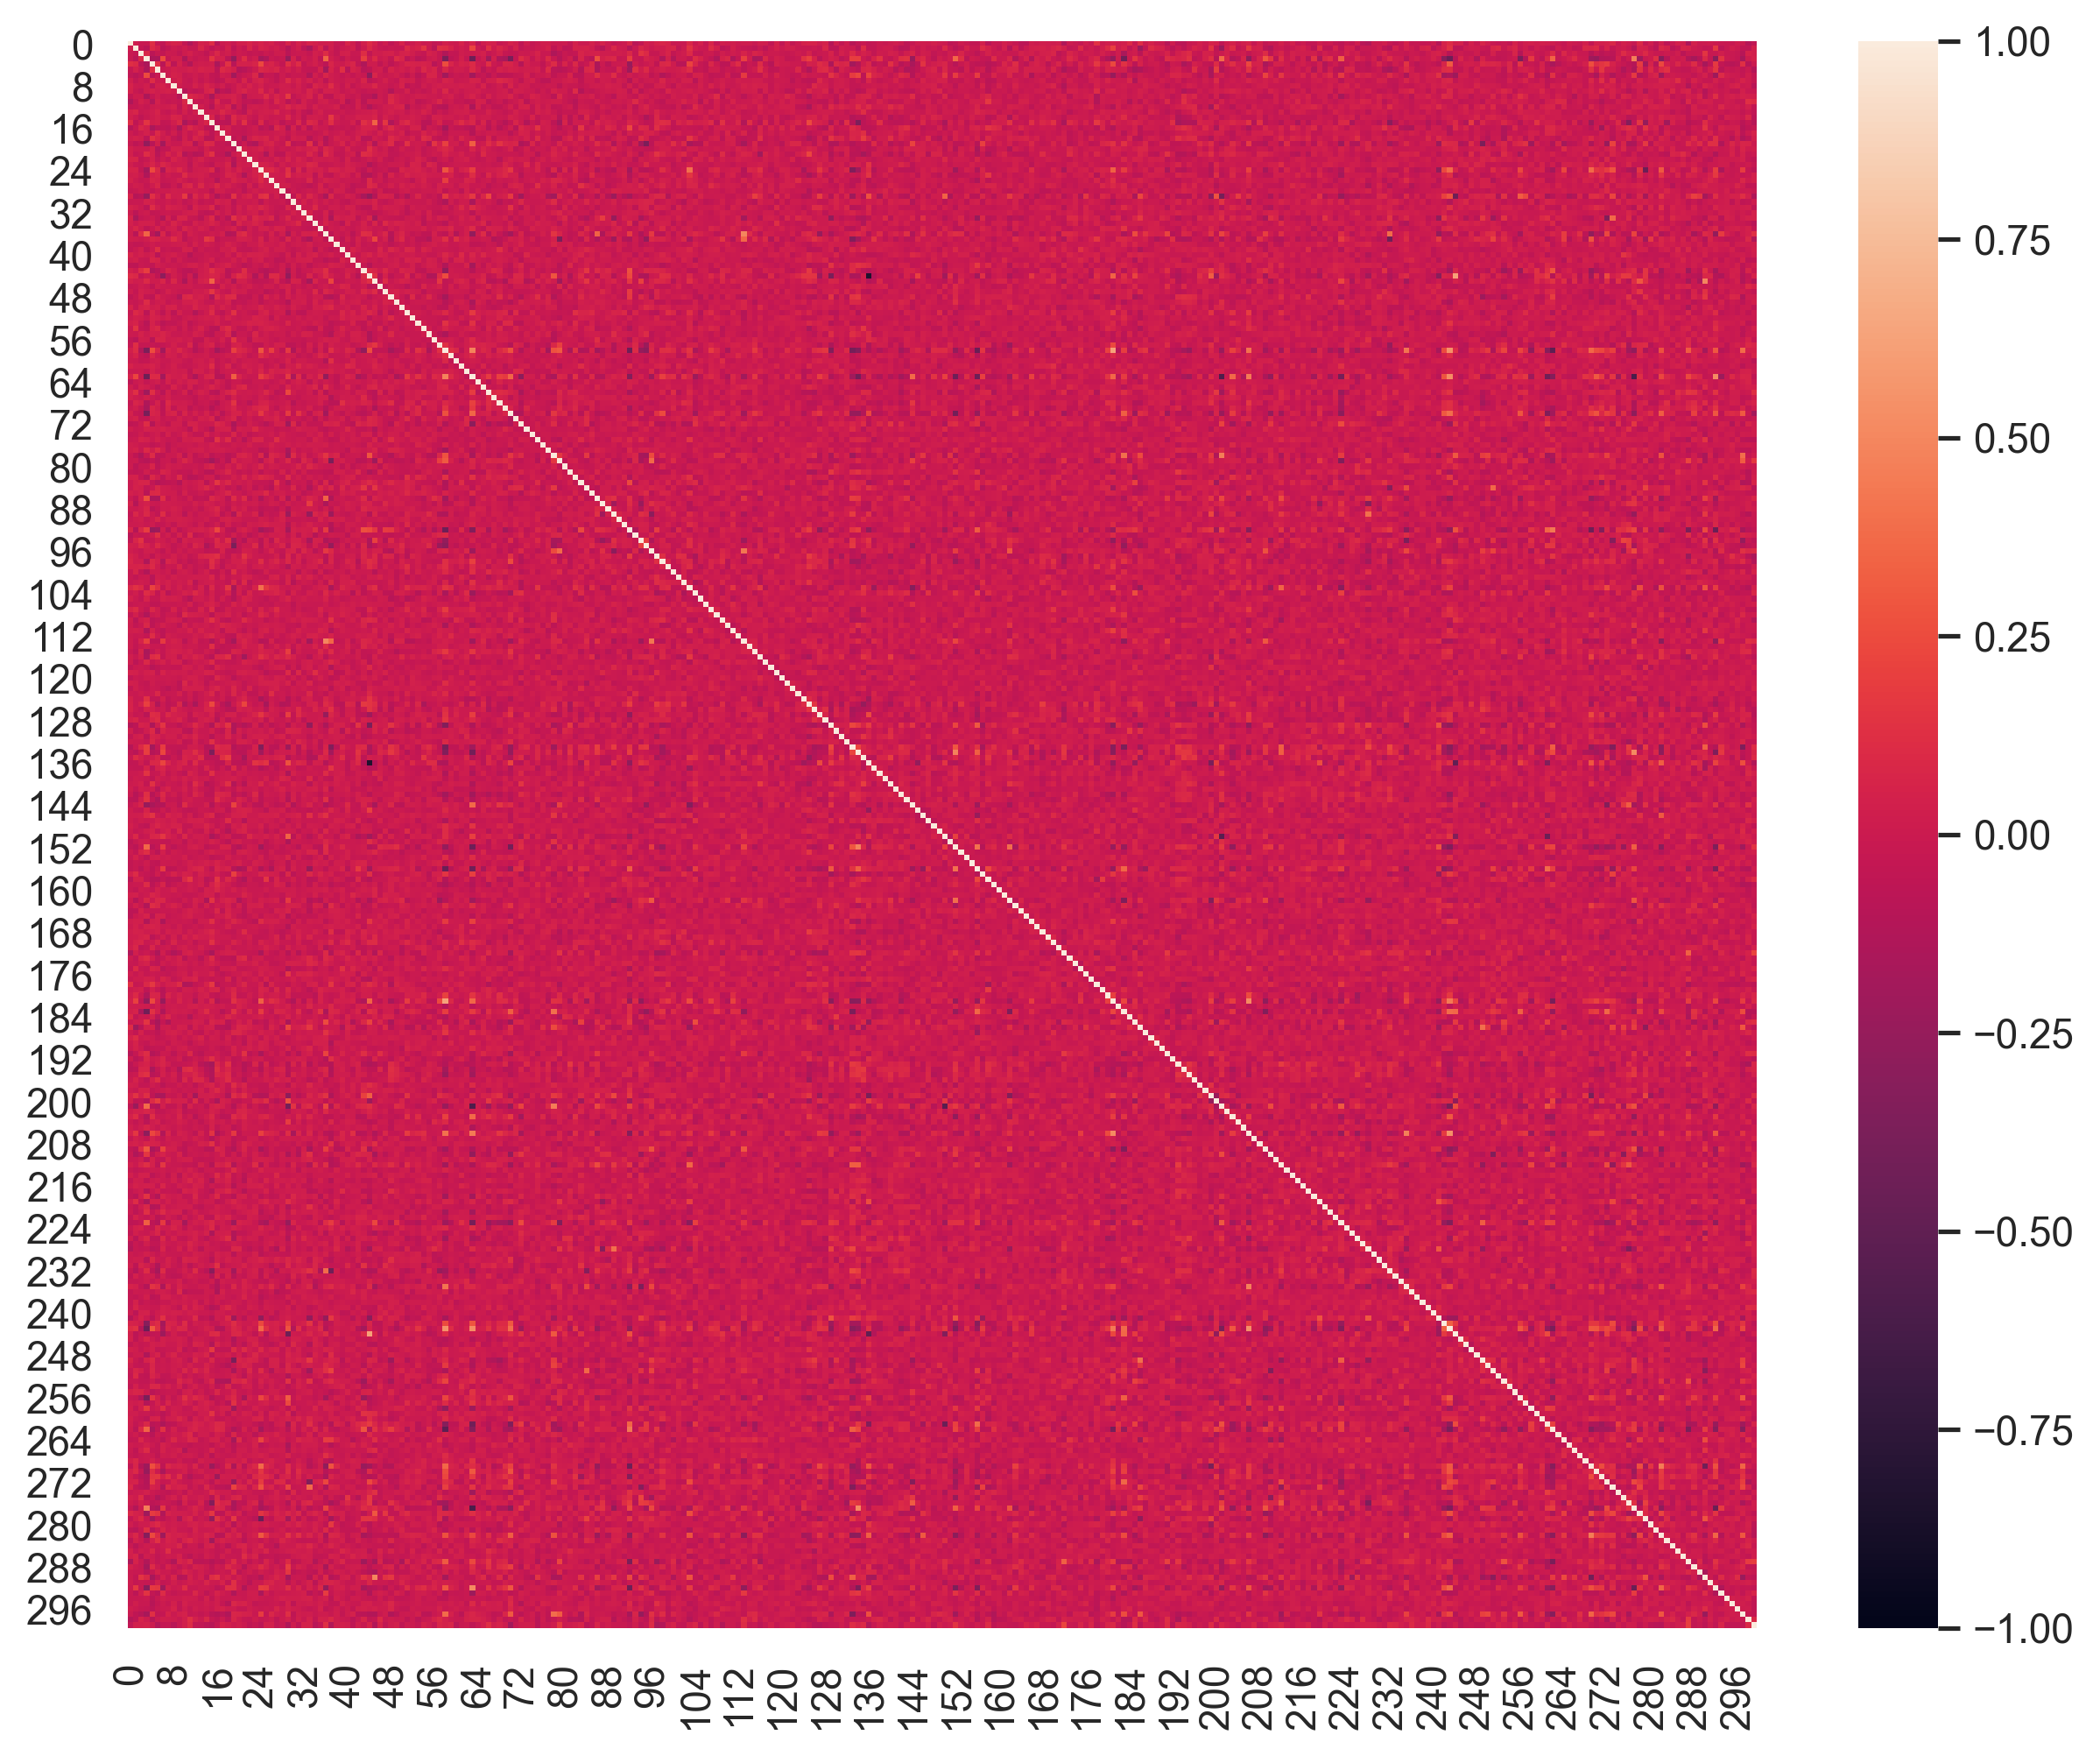

In [4]:
cc_en_corrs = correlations(cc_en, d)

### English OpenSubtitles correlations

[INFO] <function Vectors.as_df at 0x129778048> ran in 0.024 seconds


0     1     2     3     4     5     6     7     8     9    ...   290  \
0    1.00  0.05  0.03 -0.01  0.01 -0.02  0.05 -0.02 -0.04  0.00  ... -0.02   
1    0.05  1.00 -0.09 -0.19  0.15  0.13 -0.10 -0.05  0.02  0.04  ...  0.02   
2    0.03 -0.09  1.00  0.06 -0.11 -0.11  0.06 -0.01 -0.09  0.02  ... -0.01   
3   -0.01 -0.19  0.06  1.00 -0.14 -0.09  0.11  0.11 -0.08 -0.07  ...  0.04   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
296 -0.01 -0.10  0.06  0.05  0.03 -0.10  0.05  0.04 -0.03 -0.01  ... -0.24   
297 -0.01  0.06 -0.07  0.06  0.04 -0.01 -0.01  0.03  0.01 -0.00  ...  0.04   
298  0.04 -0.00 -0.02 -0.03 -0.01  0.03 -0.03 -0.04  0.05  0.01  ... -0.13   
299 -0.02 -0.09  0.10  0.06 -0.10 -0.11  0.06  0.01 -0.03  0.02  ...  0.05   

      291   292   293   294   295   296   297   298   299  
0   -0.01 -0.04  0.06  0.05  0.01 -0.01 -0.01  0.04 -0.02  
1    0.00  0.08  0.09  0.05  0.01 -0.10  0.06 -0.00 -0.09  
2    0.06 -0.03 -0.12 -0.05  0.00  0.06 -0.07 -0.02  0.10  
3    0.01 -0.09 -0.05 -0.02 -0.01  0.05  0.06 -0.03  0.06  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
296 -0.04 -0.06 -0.14 -0.14  0.04  1.00 -0.03  0.13  0.02  
297  0.00 -0.02  0.04  0.02  0.01 -0.03  1.00 -0.03 -0.01  
298 -0.04 -0.06 -0.00 -0.04 -0.00  0.13 -0.03  1.00 -0.03  
299  0.01 -0.04 -0.09 -0.04 -0.04  0.02 -0.01 -0.03  1.00  

[300 rows x 300 columns]

summary
count  90000.00
mean       0.00
std        0.04
min       -0.24
25%       -0.03
50%        0.00
75%        0.03
max        0.20

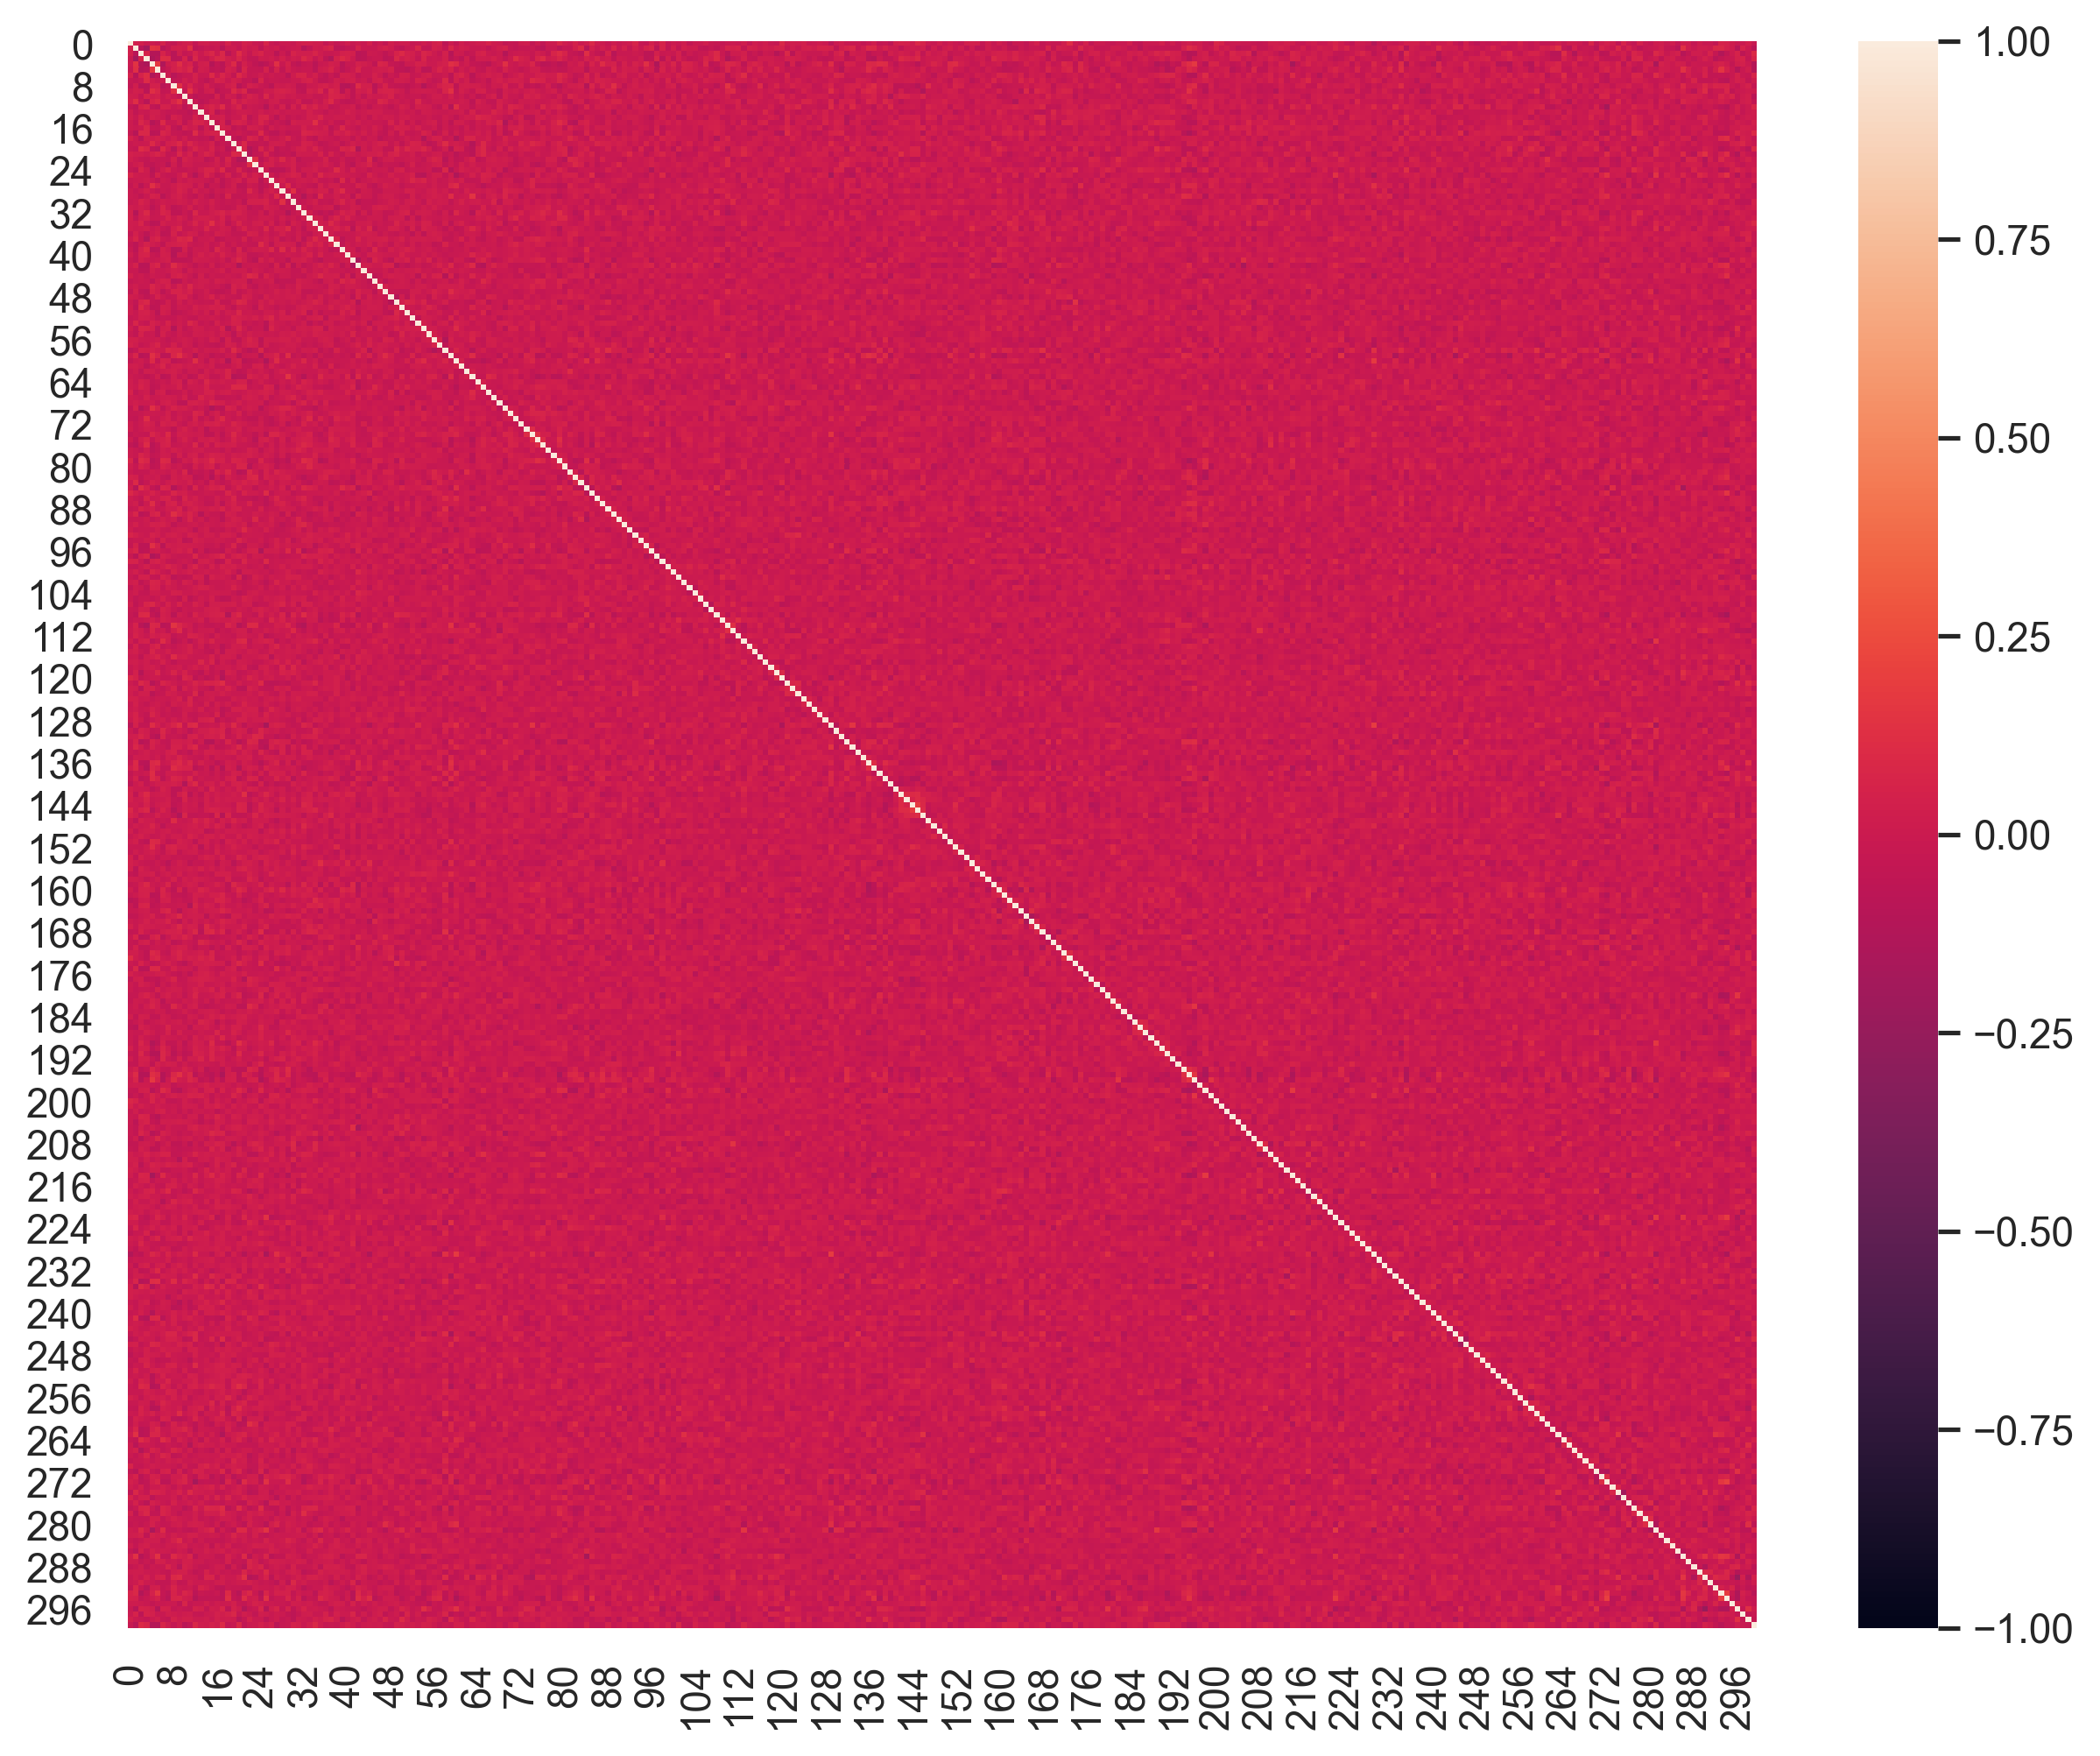

In [5]:
subs_en_corrs = correlations(subs_en, d)

### Dutch Common Crawl correlations

[INFO] <function Vectors.as_df at 0x129778048> ran in 0.025 seconds


0     1     2     3     4     5     6     7     8     9    ...   290  \
0    1.00 -0.06 -0.11  0.02 -0.02  0.06  0.06 -0.00 -0.01  0.13  ...  0.03   
1   -0.06  1.00  0.06  0.00 -0.01  0.02 -0.01 -0.03  0.00 -0.08  ...  0.02   
2   -0.11  0.06  1.00 -0.00 -0.00  0.00  0.01 -0.01 -0.02  0.03  ...  0.02   
3    0.02  0.00 -0.00  1.00 -0.01  0.01  0.02 -0.03  0.02 -0.04  ...  0.03   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
296  0.04 -0.01 -0.06 -0.01 -0.01 -0.01  0.00  0.01 -0.00  0.08  ...  0.00   
297  0.01  0.03  0.02 -0.01 -0.04 -0.00 -0.00  0.03  0.02 -0.02  ...  0.01   
298 -0.06  0.02  0.03 -0.05  0.03 -0.01 -0.05  0.01 -0.01  0.10  ...  0.00   
299 -0.04  0.03  0.03  0.02 -0.00  0.03  0.01  0.05 -0.02 -0.04  ... -0.02   

      291   292   293   294   295   296   297   298   299  
0    0.05 -0.04 -0.15  0.07  0.07  0.04  0.01 -0.06 -0.04  
1    0.01  0.03  0.00 -0.03 -0.03 -0.01  0.03  0.02  0.03  
2   -0.00  0.02  0.07 -0.06 -0.02 -0.06  0.02  0.03  0.03  
3    0.03  0.03  0.01 -0.03 -0.02 -0.01 -0.01 -0.05  0.02  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
296  0.02 -0.04 -0.06  0.05  0.03  1.00  0.06  0.01 -0.01  
297 -0.01  0.02 -0.03 -0.01  0.01  0.06  1.00  0.01  0.06  
298 -0.05  0.00  0.05  0.03  0.03  0.01  0.01  1.00 -0.01  
299  0.01  0.03 -0.02  0.02  0.03 -0.01  0.06 -0.01  1.00  

[300 rows x 300 columns]

summary
count  90000.00
mean       0.00
std        0.05
min       -0.55
25%       -0.03
50%        0.00
75%        0.03
max        0.59

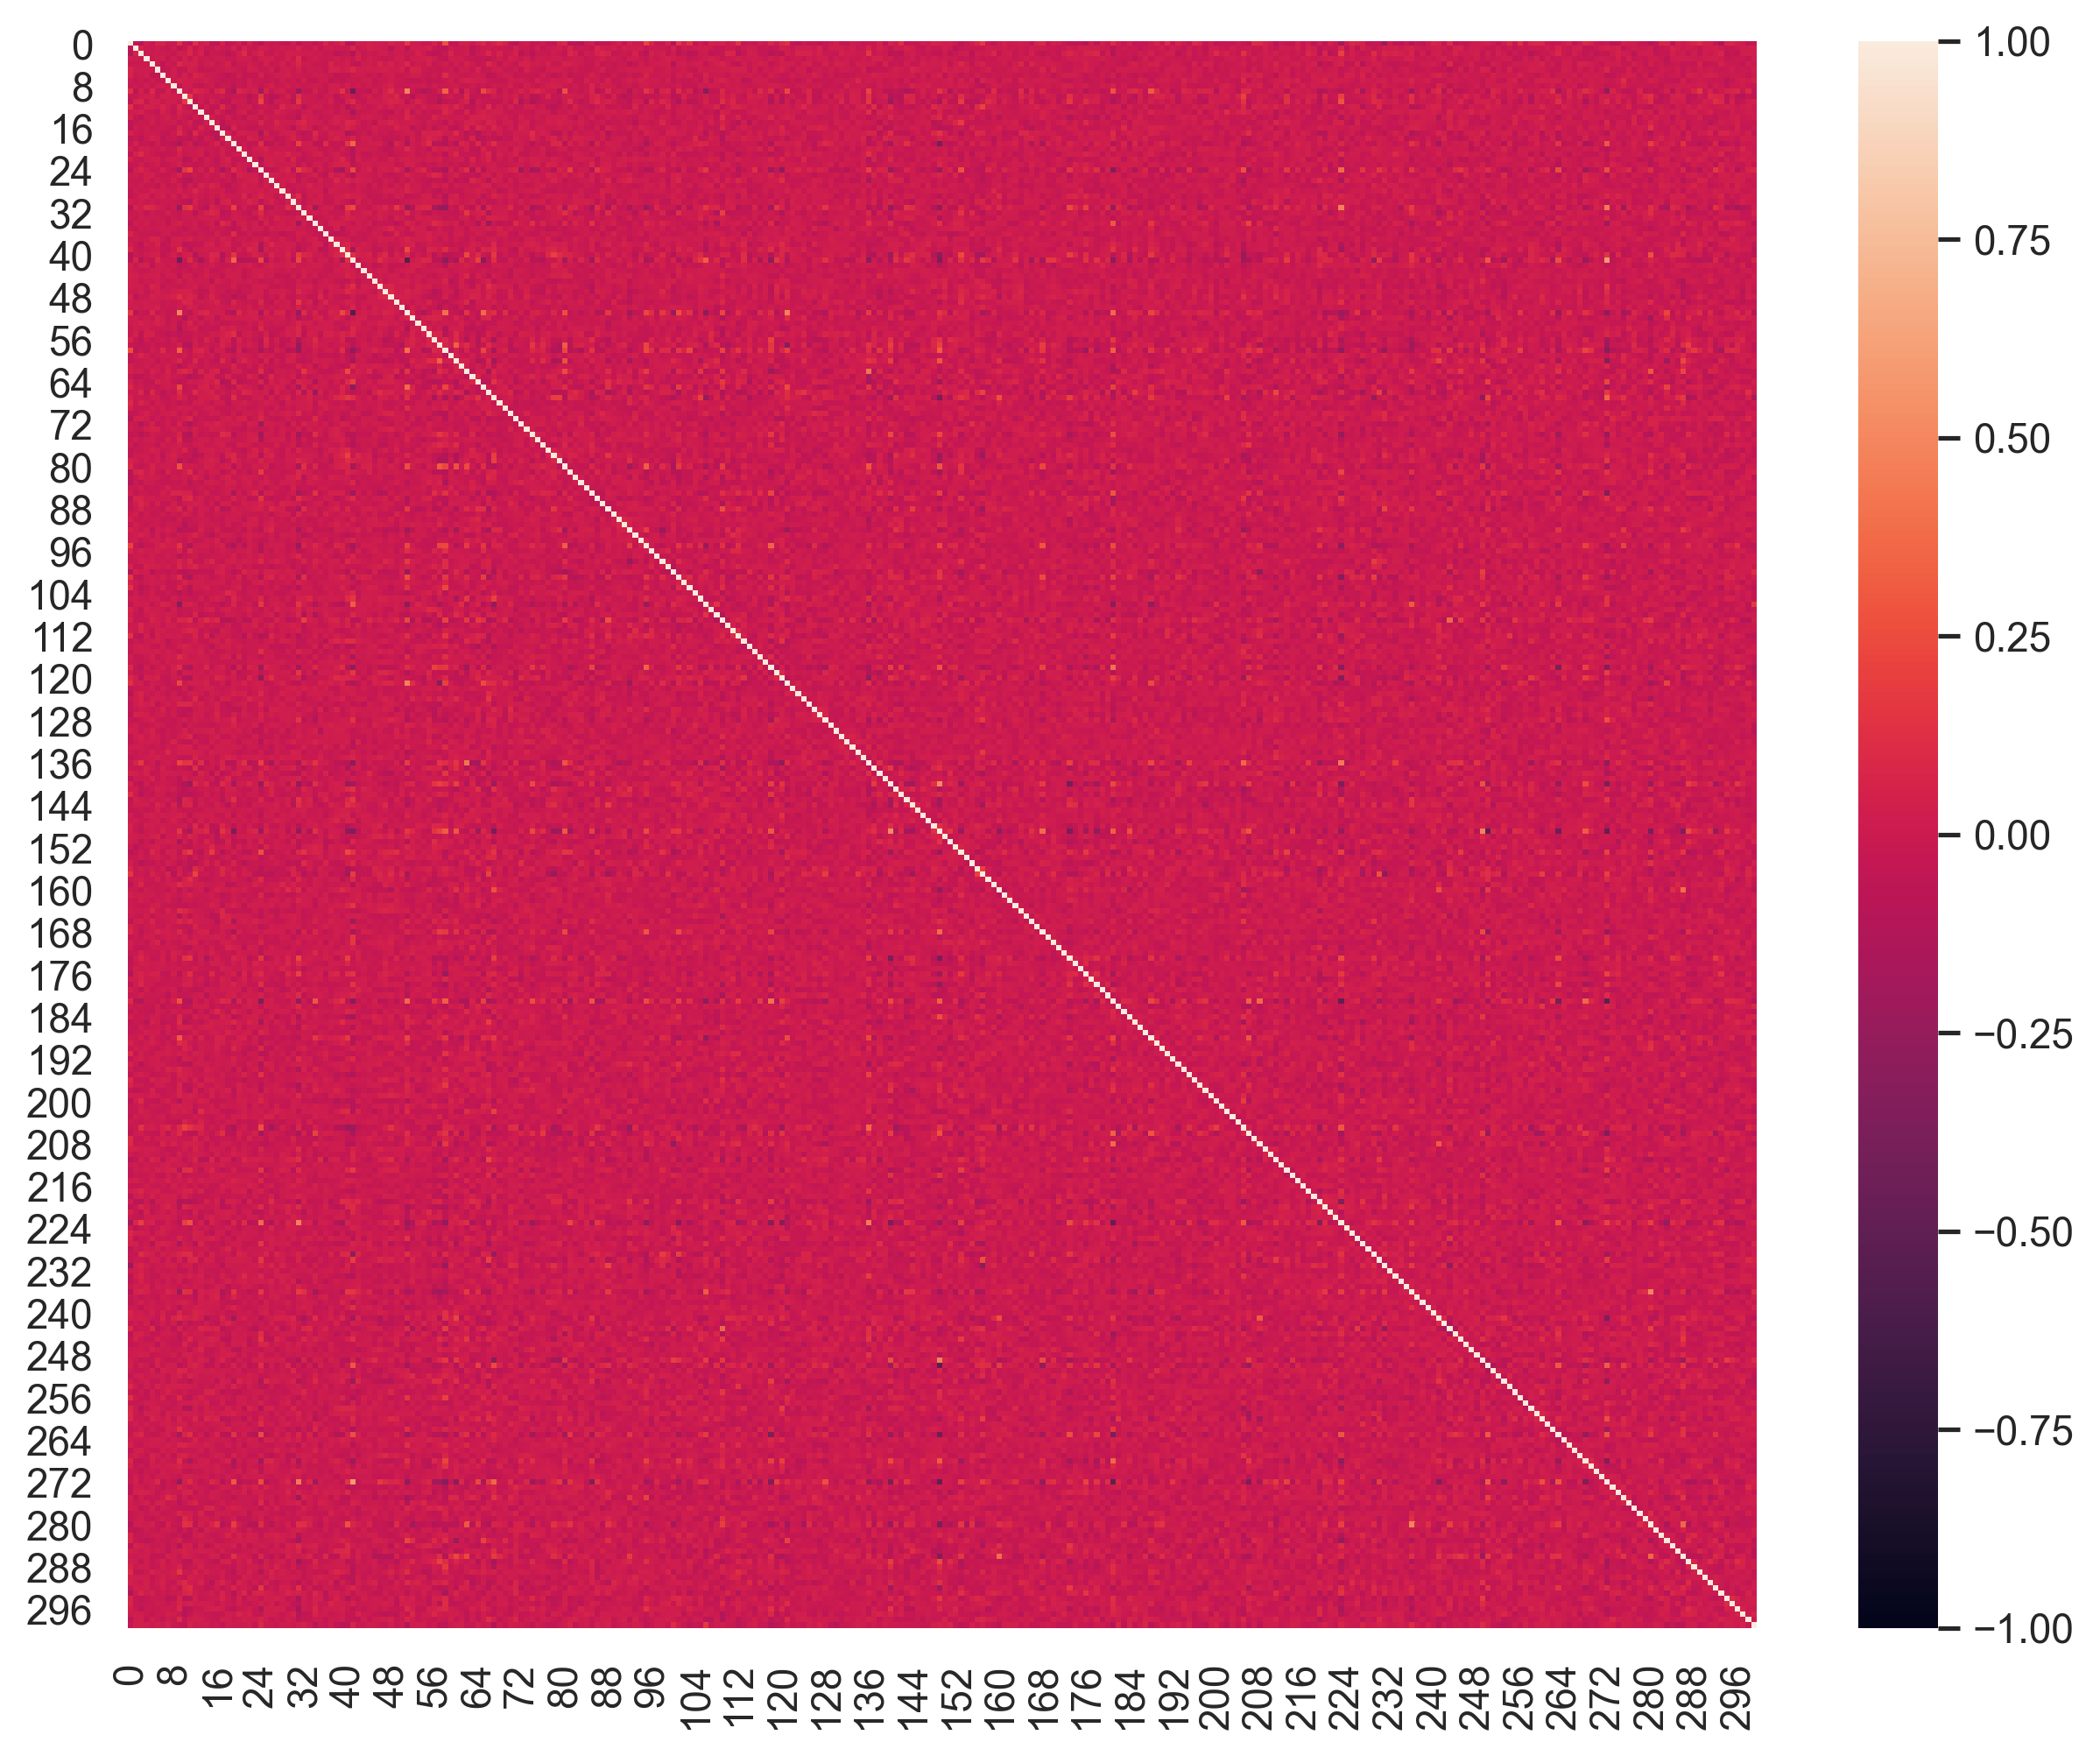

In [6]:
cc_nl_corrs = correlations(cc_nl, d)

### Dutch OpenSubtitles correlations

[INFO] <function Vectors.as_df at 0x129778048> ran in 0.025 seconds


0     1     2     3     4     5     6     7     8     9    ...   290  \
0    1.00  0.08 -0.10  0.15 -0.07  0.13 -0.09 -0.00  0.00  0.05  ...  0.08   
1    0.08  1.00 -0.01  0.12 -0.04  0.12 -0.05 -0.02  0.01  0.02  ...  0.04   
2   -0.10 -0.01  1.00 -0.07  0.09 -0.09  0.01 -0.00  0.05 -0.01  ...  0.00   
3    0.15  0.12 -0.07  1.00 -0.08  0.14 -0.08 -0.00  0.03  0.08  ...  0.08   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
296 -0.11  0.01  0.03 -0.00  0.03 -0.05 -0.02 -0.02  0.02  0.02  ...  0.03   
297  0.08  0.04 -0.08  0.05 -0.04  0.07 -0.05  0.03 -0.02  0.03  ... -0.01   
298  0.03  0.02 -0.00  0.04 -0.08  0.08 -0.07  0.02 -0.05 -0.01  ...  0.04   
299 -0.00 -0.01 -0.03 -0.01  0.03 -0.06  0.03 -0.01 -0.04 -0.01  ... -0.03   

      291   292   293   294   295   296   297   298   299  
0   -0.01 -0.02  0.03  0.06 -0.12 -0.11  0.08  0.03 -0.00  
1   -0.02  0.03  0.01  0.03 -0.05  0.01  0.04  0.02 -0.01  
2   -0.03 -0.00 -0.05 -0.06  0.05  0.03 -0.08 -0.00 -0.03  
3   -0.05  0.03 -0.03 -0.02 -0.09 -0.00  0.05  0.04 -0.01  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
296 -0.05  0.08  0.02 -0.03  0.08  1.00 -0.13 -0.06 -0.03  
297 -0.07  0.05 -0.10  0.04 -0.10 -0.13  1.00  0.15  0.15  
298 -0.03  0.03 -0.01  0.02 -0.06 -0.06  0.15  1.00  0.02  
299 -0.03  0.01 -0.01  0.03  0.01 -0.03  0.15  0.02  1.00  

[300 rows x 300 columns]

summary
count  90000.00
mean      -0.00
std        0.04
min       -0.26
25%       -0.02
50%        0.00
75%        0.02
max        0.28

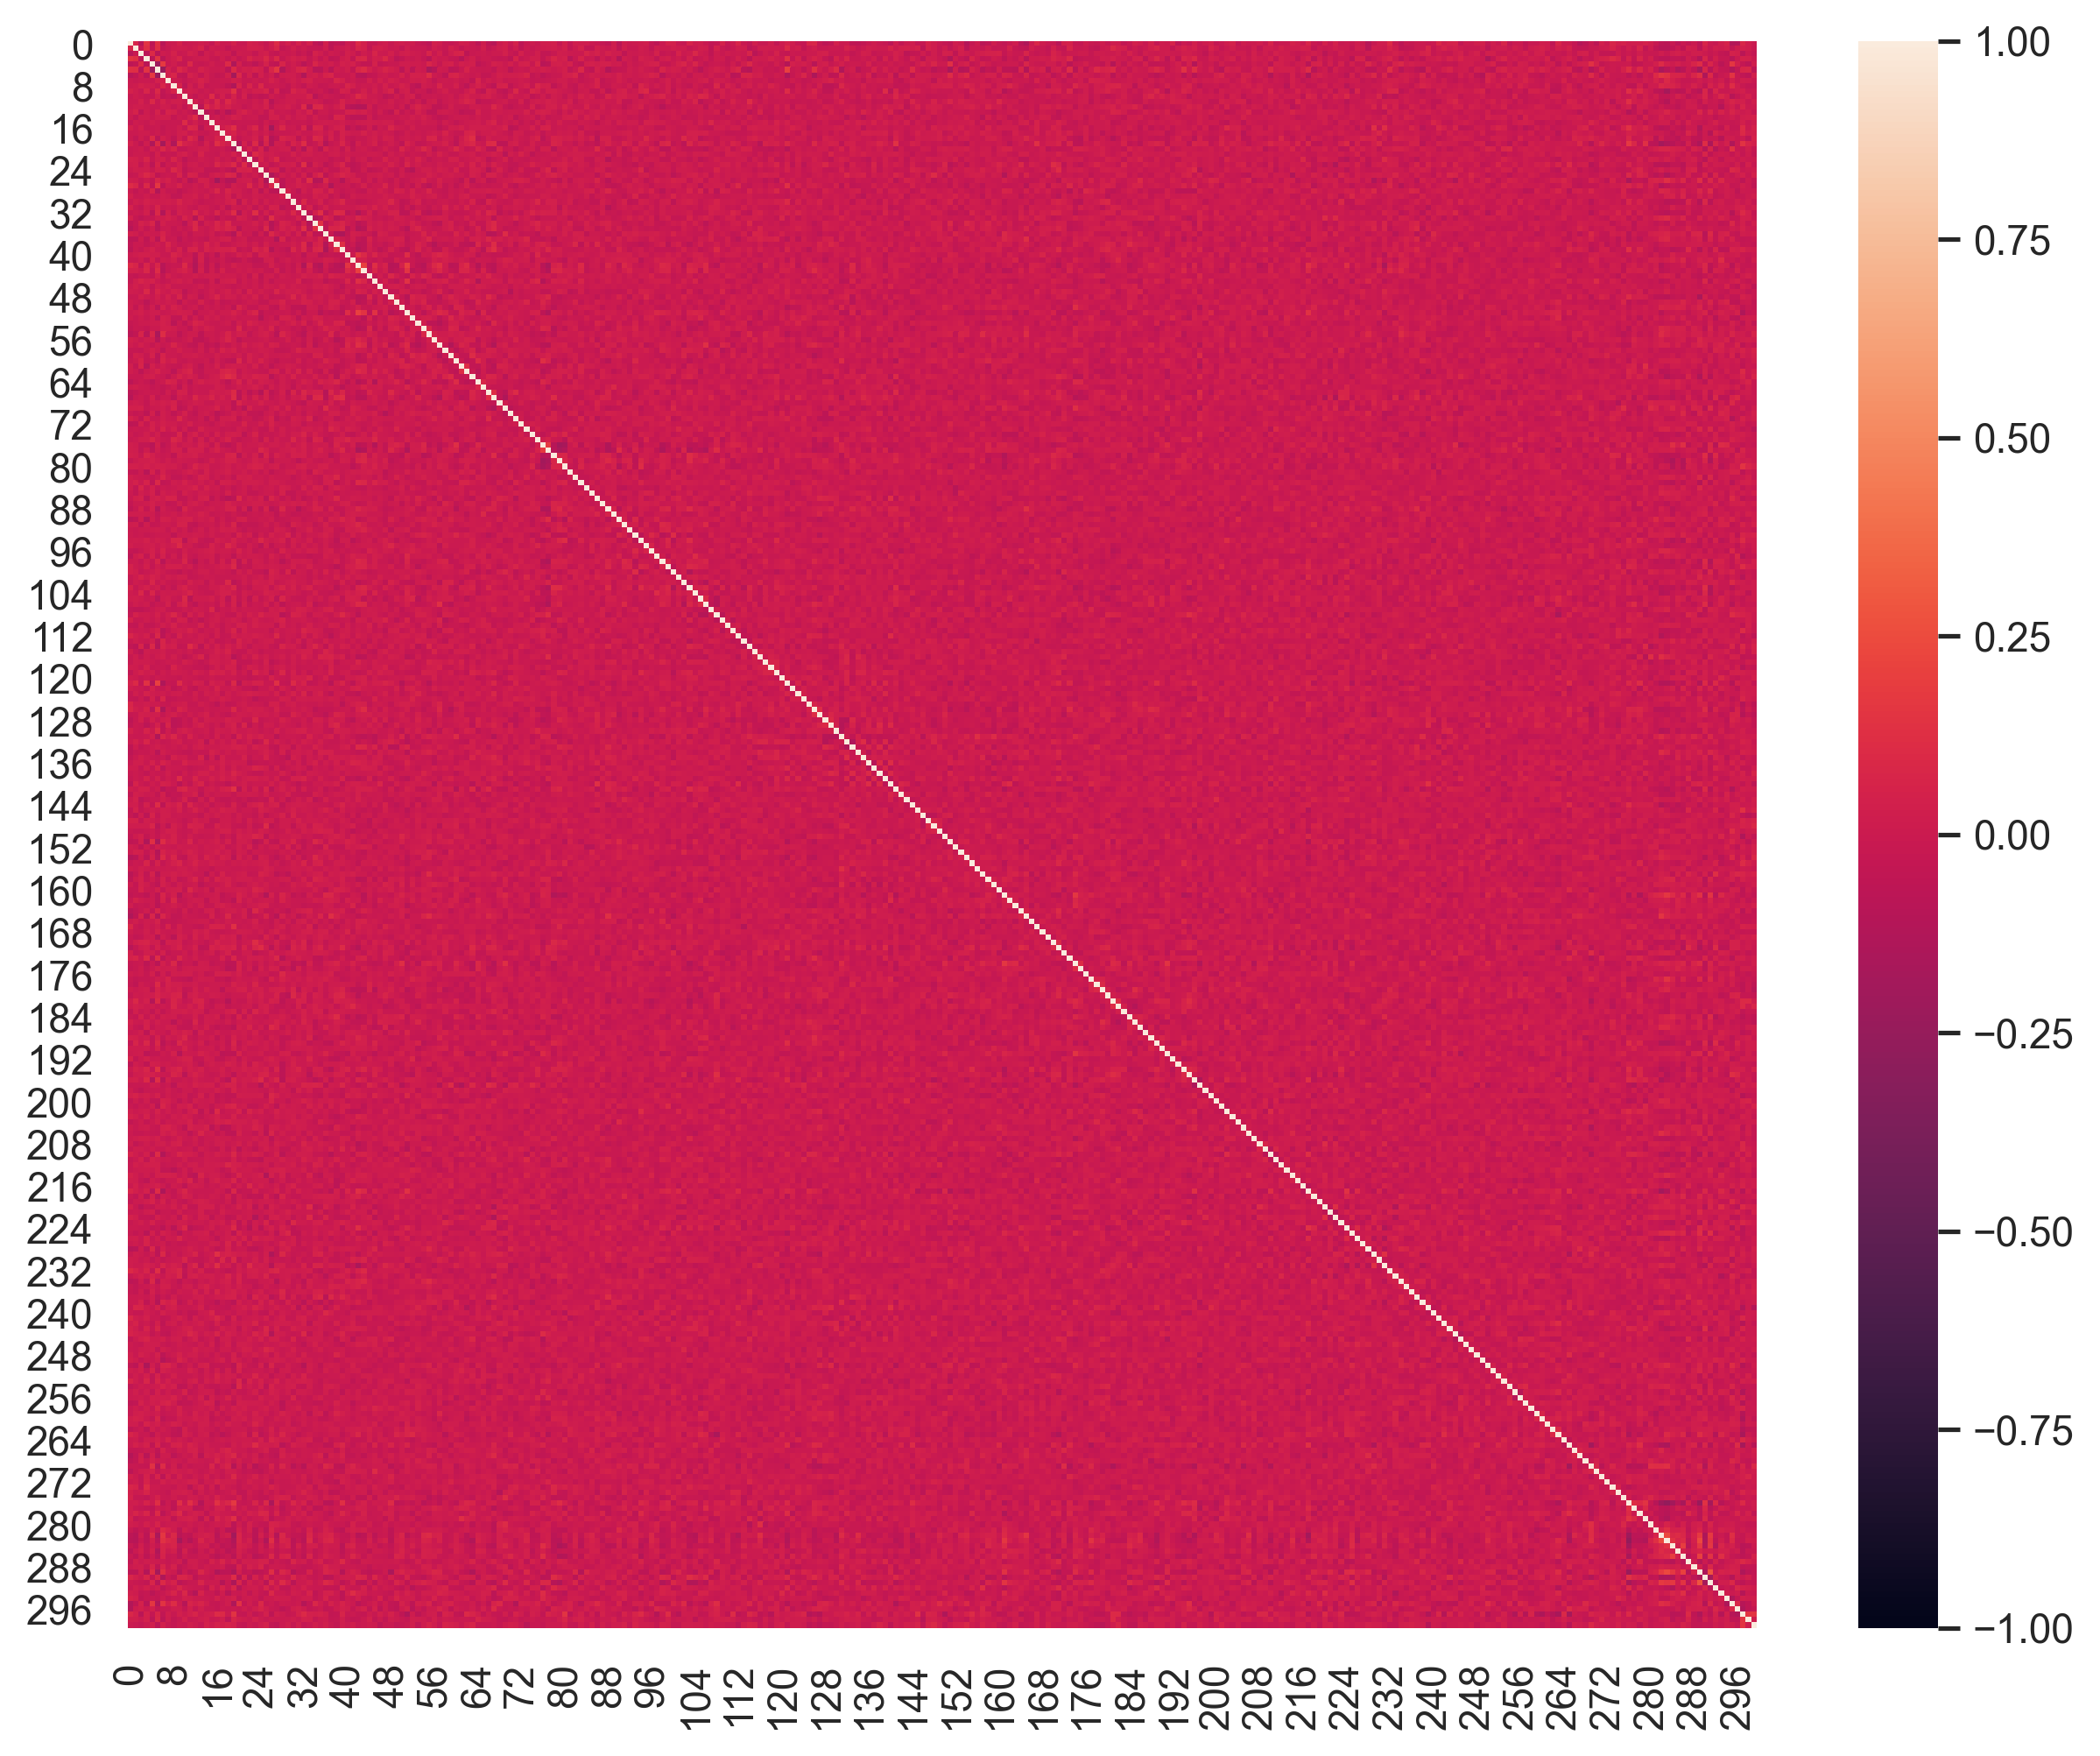

In [7]:
subs_nl_corrs = correlations(subs_nl, d)

# Decompositions
## Principal Components Analysis

In [8]:
from subs2vec.neighbors import compute_nn
pd.set_option('display.max_rows', None)
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

In [9]:
def pca_neighbors(vecs, d, num_neighbors=6):
    pca = PCA(d)
    components = pca.fit(vecs.vectors).components_
    labels = np.array(list(range(d)))
    neighbors = compute_nn(vecs, components, labels, num_neighbors, whole_matrix=True)
    display(neighbors)
    return neighbors, components

### English Common Crawl PCA

In [10]:
cc_en_pca_nn, cc_en_pca_comp = pca_neighbors(cc_en, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.005 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.306 seconds


target        neighbor 0        neighbor 1      neighbor 2  \
0        0            School                29             Art   
1        1                So              Yeah          Anyway   
2        2             Based           Further    Introduction   
3        3      acknowledged          founding     established   
4        4                30                20              12   
5        5            opened             moved        launched   
6        6             email            e-mail            Dave   
7        7            people         companies      businesses   
8        8        delightful          colorful       wonderful   
9        9      announcement              post       yesterday   
10      10           labeled            copied        invented   
11      11             types            places            Some   
12      12            deaths          injuries         wounded   
13      13           explore      surroundings           relax   
14      14            honour             honor          hearts   
15      15         launching        developing         pushing   
16      16              sell       manufacture            1946   
17      17              bold          comments     highlighted   
18      18             theft            stolen     destruction   
19      19         predicted          analyzed      downloaded   
20      20         investing           selling          buying   
21      21                 ¯                 ¿               §   
22      22     participating          eligible       alternate   
23      23           average             falls         Average   
24      24       investigate           Another         examine   
25      25         biography              1931            1911   
26      26           manages             takes        produces   
27      27      occasionally          occasion        presence   
28      28            listen          audience      television   
29      29          delivers          performs        protects   
30      30         community         volunteer         ongoing   
31      31        Lieutenant               Sir         Colonel   
32      32            abroad            sleeve         shorter   
33      33             sends           reminds        commands   
34      34          accurate           healthy       healthier   
35      35        Production        photograph         footage   
36      36              aims              uses      suggestion   
37      37           travels           Railway        Railroad   
38      38             signs         sculpture             art   
39      39         organised     organisations    organisation   
40      40         replacing              21st       commander   
41      41         secondary         chemistry           loses   
42      42              hunt      Nevertheless         However   
43      43              chef        restaurant        achieved   
44      44      Presidential          outdoors      meaningful   
45      45            behalf          directly      comparison   
46      46         direction        directions         desired   
47      47           artists            makers          judges   
48      48         behaviour           accepts      thoroughly   
49      49             crowd               PHP    difficulties   
50      50      introduction            basics             Act   
51      51          programs              menu        missions   
52      52             rated           bedroom            zone   
53      53            option            yellow          colour   
54      54            flavor      considerably         greatly   
55      55        passengers         travelers       enjoyable   
56      56            Period            period            wing   
57      57          Location          location          option   
58      58           retreat           monthly           guest   
59      59            prayer           prayi

### English OpenSubtitles PCA

In [11]:
subs_en_pca_nn, subs_en_pca_comp = pca_neighbors(subs_en, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.007 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.305 seconds


target      neighbor 0      neighbor 1          neighbor 2  \
0        0            Jess          Maggie               Katie   
1        1          bucket        slippers               juice   
2        2         jealous         despise            offended   
3        3          phoned        arrested        Good_evening   
4        4         nations      Christians             knights   
5        5            OKAY       ALL_RIGHT             COME_ON   
6        6            fled          chased            vanished   
7        7     celebrities       teenagers         restaurants   
8        8           Shall             Now            Allow_me   
9        9   motherfuckers        assholes                cops   
10      10        gangster     businessman                pimp   
11      11       rehearsal         stadium            cheering   
12      12      six_months    three_months           six_weeks   
13      13       Otherwise         Even_if          Either_way   
14      14        sensible      unpleasant           efficient   
15      15        stabbing        comments            contempt   
16      16         dumping          buying            stealing   
17      17       medicines            Mean       getting_worse   
18      18          reject         destroy             Vatican   
19      19            male          female               adult   
20      20         pudding           roast                soup   
21      21            1000             300                 200   
22      22         science         library               Bible   
23      23       equipment         wrecked             awesome   
24      24       producing     experiments               jumps   
25      25      ambassador       receiving                lady   
26      26        studying      practicing            applying   
27      27         sobbing      television           telephone   
28      28      experience          combat              luxury   
29      29            dish      restaurant             counted   
30      30      20_minutes     few_minutes          30_minutes   
31      31            text          laptop             texting   
32      32           rally        festival            donation   
33      33            mate           mates             website   
34      34        leverage        demanded                 mob   
35      35            Oppa          calmly     without_knowing   
36      36          Palace        gambling              casino   
37      37         arrives        wakes_up               picks   
38      38           tiger            lion                cage   
39      39            pays          scares             bothers   
40      40         cabinet       household              united   
41      41          autumn         produce              colors   
42      42       classroom          drawer                  ah   
43      43             cos             BBC           programme   
44      44          repair         rebuild           ancestors   
45      45          Miguel            Luis                Rico   
46      46       behaviour    intelligence             display   
47      47         fishing        relaxing            peaceful   
48      48         satisfy         ex_wife           apartment   
49      49       operation      operations            secretly   
50      50         apology        solution                Army   
51      51         betting           lungs               fatal   
52      52            lawn     interrupted                 nap   
53      53      background           royal               Elvis   
54      54       paintings            Duke            inspired   
55      55            wolf         closing              cancel   
56      56       predicted         predict            constant   
57      57            cage            owed                vase   
58      58          decade         century                 sec   
59      59         cavalry            camp  

### Dutch Common Crawl PCA

In [12]:
cc_nl_pca_nn, cc_nl_pca_comp = pca_neighbors(cc_nl, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.008 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.313 seconds


target                 neighbor 0                       neighbor 1  \
0        0                          A                                M   
1        1                  Overigens                             zegt   
2        2                          %                               45   
3        3                       1930                             1925   
4        4                Presentatie                           Advies   
5        5              Verschillende                           Andere   
6        6                  aangeduid                     geïntegreerd   
7        7         vertegenwoordigers                      betrokkenen   
8        8                  politicus                        dergelijk   
9        9                   Duurzaam                             Goed   
10      10                    RCE.jpg                       RD1-team09   
11      11                stabiliteit                             mate   
12      12                 afsluiting                              Ter   
13      13                      stuks                              per   
14      14                   tekening                       achterkant   
15      15                   sfeervol                           modern   
16      16                    betaalt                           betaal   
17      17              toevoegenMeer                           loggen   
18      18        bezienswaardigheden                          ligging   
19      19                  werkgroep                     spinnensoort   
20      20                 Zuid-Korea                         Slovenië   
21      21                     gebeld                       gereageerd   
22      22                     Zwolle                          Haarlem   
23      23                     ideale                         perfecte   
24      24                     Vanuit                            Zodra   
25      25               Tegenwoordig                        voorloper   
26      26                 gewoonlijk                       inbegrepen   
27      27                       love                            clubs   
28      28                  lancering                               de   
29      29                       haar                          voedsel   
30      30                 RD1-team10                       RD1-team06   
31      31                     podium                       artistieke   
32      32                   optreedt                           treedt   
33      33                  televisie                       literatuur   
34      34                  contacten                         bovenaan   
35      35               grondstoffen                         gewonnen   
36      36                  scheiding                   overeenkomsten   
37      37                  voorlopig                               09   
38      38                    uitstek                      voorstander   
39      39                   Groetjes                            sinds   
40      40                Hymenoptera                 vliesvleugeligen   
41      41          vertegenwoordigen                              enz   
42      42                   opzichte                       RD1-team12   
43      43                    proeven                          experts   
44      44                  Productie                       beoordelen   
45      45                     geluid                            genot   
46      46                 nauwkeurig                      betrouwbaar   
47      47                   syndroom                        herkennen   
48      48                  opgericht                       oprichting   
49      49                bevoegdheid                     bevoegdheden   
50      50                    middels                       verrichten   
51      51               verwijdering                        nominatie   
52      52                 veranderde                         culturen   
53      

### Dutch OpenSubtitles PCA

In [13]:
subs_nl_pca_nn, subs_nl_pca_comp = pca_neighbors(subs_nl, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.005 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.313 seconds


target          neighbor 0        neighbor 1      neighbor 2  \
0        0               Jenny           Heather           Katie   
1        1  met_betrekking_tot      geïnformeerd   betrokkenheid   
2        2          voertuigen      vrachtwagens     satellieten   
3        3                Haal             Breng             Zet   
4        4                Maar          Daardoor              Ze   
5        5        neergestoken          beweerde            werd   
6        6         restaurants            hoeren        feestjes   
7        7            rebellen         verraders       bandieten   
8        8             dienaar          strijder        verrader   
9        9             dealers         smerissen      criminelen   
10      10          achterlijk               maf            saai   
11      11          Twee_dagen          paar_uur      twee_dagen   
12      12         zes_maanden      terugbetalen        per_jaar   
13      13            kostbaar         waardevol      afgeleverd   
14      14          officieren         bedienden   verpleegsters   
15      15             bezoekt         verblijft      prostituee   
16      16            training        geopereerd        getraind   
17      17        opgeschreven         verzonden       berichten   
18      18         behoorlijke        eenvoudige       heerlijke   
19      19           voorlezen        bestuderen         genezen   
20      20            vijftien           twintig          twaalf   
21      21           neergezet          uitgezet        gesleept   
22      22              tehuis          weeshuis       Achteruit   
23      23         vuurgevecht      verkrachting      ontvoering   
24      24         bespioneren           complot       saboteren   
25      25              straks      fantastische      bijzondere   
26      26           miljonair         instorten            Arme   
27      27          dochtertje         littekens         zoontje   
28      28           adopteren         schattige           alien   
29      29          connecties         contacten          Mexico   
30      30          definitief      overeenkomst     klootzakken   
31      31          makkelijke           bedacht       gedwongen   
32      32             uniform         mariniers        medaille   
33      33            Colombia     ervoor_zorgen        kalmeren   
34      34            verdomme       godverdomme        Godsnaam   
35      35        rechercheurs           burgers         agenten   
36      36            zaterdag     zaterdagavond    vrijdagavond   
37      37            wonderen            handje          wonder   
38      38              draken          Koningin           draak   
39      39        veroordeling         aanklager         18_jaar   
40      40            barbecue        volle_maan            kerk   
41      41              lichte         depressie         innemen   
42      42                 tas            rugzak       Professor   
43      43             verwond          toernooi          ribben   
44      44               kunst        kunstenaar         veiling   
45      45         voorbestemd            plicht         gekozen   
46      46            New_York            Gotham         Atlanta   
47      47               match        dierentuin            Hope   
48      48             aanvalt           diploma       aanvallen   
49      49            straffen             straf         scholen   
50      50         verbetering           kruipen      binnenkant   
51      51         Wall_Street             leeuw      financiële   
52      52            schreeuw         afgewezen           huren   
53      53               kabel        verbinding         netwerk   
54      54            afdeling        feestdagen        Kerstmis   
55      55         achtervolgt      achtervolgen             rit   
56      56       vicepresident         president          schuur   
57      57               fluit             schot          st

## Factor Analysis

In [14]:
def fa_neighbors(vecs, d, num_neighbors=6, rotation=None):
    fa = FactorAnalysis(d, rotation=rotation)
    components = fa.fit(vecs.vectors).components_
    labels = np.array(list(range(d)))
    neighbors = compute_nn(vecs, components, labels, num_neighbors, whole_matrix=True)
    display(neighbors)
    return neighbors, components

### English Common Crawl FA

In [15]:
cc_en_fa_nn, cc_en_fa_comp = fa_neighbors(cc_en, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.007 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.196 seconds


target    neighbor 0    neighbor 1      neighbor 2     neighbor 3  \
0        0            29            27          School            Art   
1        1          Yeah             I          Anyway             So   
2        2        wooden          wood         plastic            ice   
3        3           Use         Check            Make            Try   
4        4            31            14              30             12   
5        5             ï            53              57             47   
6        6     contacted          sent       requested          email   
7        7          Many          Most          people          Those   
8        8    delightful      colorful       featuring       featured   
9        9          week       evening            blog         Friday   
10      10       labeled        copied        appeared     originally   
11      11       Several          Some           those          Among   
12      12       wounded      suffered        attacked         killed   
13      13       explore  surroundings           visit        located   
14      14        honour         honor           prize        receive   
15      15       connect      connects          engage          joins   
16      16          1946   manufacture            1958           1953   
17      17        taught      training         therapy        classes   
18      18        stolen          owns           sells      destroyed   
19      19        showed         hoped      tremendous       analyzed   
20      20      detected        sample        infected      diagnosed   
21      21   spectacular     memorable      unexpected         deadly   
22      22     promoting     producing     introducing     presenting   
23      23         tends         falls          varies       performs   
24      24           One       Another     investigate            Two   
25      25     biography    historical      Historical           1931   
26      26       manages         takes          serves          sends   
27      27      presence  occasionally        occasion           fans   
28      28          fare          taxi         Economy       audience   
29      29     community    non-profit       nonprofit        created   
30      30           air      performs       equipment  demonstration   
31      31        Cheers   populations      volunteers      volunteer   
32      32         cover            UK           wider      programme   
33      33       reminds    adjustment        supports          sends   
34      34    suggestion   suggestions        mentions        cuisine   
35      35       intense   specialized             Due    experienced   
36      36         Along           Our        reliable  comprehensive   
37      37   prestigious      renowned      excellence         boasts   
38      38        crisis     organised             key         tricky   
39      39         signs          sign          street   intersection   
40      40     recording     announces            hear     recordings   
41      41     agreement     voluntary            Blue     agreements   
42      42           5th           6th             3rd            2nd   
43      43  Presidential  presidential          ballot    scholarship   
44      44        showed        police    headquarters          Their   
45      45       arrives         finds          packed         lineup   
46      46  alternatives   alternative       direction     eliminated   
47      47          poor       whereas   Unfortunately        However   
48      48    accomplish           His           hopes            Him   
49      49    immigrants   citizenship           basic      amendment   
50      50      requests   encountered         demands        product   
51      51         guide          menu        guidance         Angels   
52      52         rated        ranked           grade        highest   
53      53          zone         chose           zones        

### English OpenSubtitles FA

In [16]:
subs_en_fa_nn, subs_en_fa_comp = fa_neighbors(subs_en, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.007 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.206 seconds


target     neighbor 0     neighbor 1      neighbor 2     neighbor 3  \
0        0           Jess         Maggie           Katie           Beth   
1        1         bucket          juice        slippers           cans   
2        2        jealous       offended         despise        ashamed   
3        3         shapes    essentially     potentially    environment   
4        4        nations     Christians          Romans         saints   
5        5           OKAY      ALL_RIGHT         COME_ON           SOME   
6        6     Ever_since           fled          chased     supposedly   
7        7          spear          sword          dagger        traitor   
8        8            Now          Shall        Allow_me      Very_well   
9        9  motherfuckers       assholes       gangsters           cops   
10      10       gangster       comedian      politician           punk   
11      11       cheering      rehearsal         rushing    celebration   
12      12     six_months   three_months            year     five_years   
13      13    represented   representing         handles           hats   
14      14       sensible     unpleasant             sir        fellows   
15      15       stabbing       repeated        comments     complaints   
16      16         filthy           vile           filth      humiliate   
17      17        In_fact   Nevertheless      Either_way           Well   
18      18        dumping      poisoning         feeding       bringing   
19      19           male         female         females          nurse   
20      20      delicious          fried             Ugh          roast   
21      21         church     philosophy      foundation      education   
22      22    competition       Shanghai      eliminated          Milan   
23      23     impressive       pathetic         awesome    magnificent   
24      24         invent    experiments      experiment      invention   
25      25      receiving        shining         manager   commissioner   
26      26            bro         brutal           innit           gang   
27      27       studying       sticking  worrying_about        drawing   
28      28          claws       canceled         refuses      next_year   
29      29         helmet           gear      motorcycle          Spain   
30      30     20_minutes      two_hours      45_minutes       24_hours   
31      31       backpack         laptop     Afghanistan   few_days_ago   
32      32       donation         donate       publicity        perform   
33      33           chat          mates            mate           worm   
34      34           Oppa           Chan            Fish           fish   
35      35         survey      commander      front_page     journalist   
36      36        Vatican       wakes_up            Pope         Brazil   
37      37           Chen          Chang          Boston       bad_luck   
38      38         insult    hospitality          offend  swimming_pool   
39      39         safely         voyage        stranded        journey   
40      40        cabinet           ward         retired      classroom   
41      41         banned       punished         printed            Cos   
42      42        Problem         fucked              Us          mates   
43      43           1_00            500             300            600   
44      44          waltz  clears_throat         distant         autumn   
45      45       fountain    volunteered         academy      marijuana   
46      46        behaved      behaviour    intelligence     remarkable   
47      47       peaceful       relaxing           relax         Police   
48      48     ex_husband        Vietnam         ex_wife       Pentagon   
49      49      forensics        kicking       Australia          breed   
50      50         hungry           ribs            menu        twisted   
51      51           Club         clinic         doctors        betting   
52      52      recommend    

### Dutch Common Crawl FA

In [17]:
cc_nl_fa_nn, cc_nl_fa_comp = fa_neighbors(cc_nl, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.007 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.202 seconds


target        neighbor 0      neighbor 1      neighbor 2  \
0        0                 A               M              Xã   
1        1              1973            1976            1938   
2        2                 !              En              Ja   
3        3              1920            1900            1930   
4        4           Analyse     Presentatie         Rapport   
5        5          compacte    geavanceerde          fraaie   
6        6         opgehaald      aangesteld   geïnstalleerd   
7        7         Nederland          Europa          Almere   
8        8           weekend        Vakantie        Onderweg   
9        9          talrijke         diverse   verschillende   
10      10           release            game          script   
11      11           beroemd        populair  internationaal   
12      12              e.d.       Artikelen          lijken   
13      13        RD1-team02      RD1-team06      RD1-team12   
14      14          services         comfort   optimaliseren   
15      15          betaalde          betaal        eigenaar   
16      16     professioneel            jong        creatief   
17      17               zet           haalt           bouwt   
18      18         Carabidae          Apidae    Oecophoridae   
19      19            waarde            Koop          draagt   
20      20      respondenten      onderzocht         rapport   
21      21            wonnen         prijzen      doelpunten   
22      22               one             are             600   
23      23         ministers       parlement        liberale   
24      24             Enkel         Bekende       voormalig   
25      25     indrukwekkend          helder     schitterend   
26      26                uw     ambassadeur            huid   
27      27        bestuderen          studie            boek   
28      28          regering        federale        Regering   
29      29         concerten       optredens        lezingen   
30      30               Hem         evenwel     voortdurend   
31      31       Association      activiteit       expeditie   
32      32          uitgeven        verlagen           dalen   
33      33          failliet          rechts           plots   
34      34             event        Brussels             not   
35      35          Hopelijk       momenteel       Brusselse   
36      36             steun       vergroten         plaatje   
37      37         avonturen        spannend           serie   
38      38    geïntroduceerd       gecreëerd       generatie   
39      39           fietsen           fiets             wet   
40      40       uitbreiding         vleugel           steun   
41      41              haha            gaaf             lol   
42      42      fotograferen        vlinders      loopkevers   
43      43             their          little             our   
44      44               vzw    initiatieven      gelanceerd   
45      45          syndroom         kortweg             HTC   
46      46        prostomium         trailer         dinsdag   
47      47        Controleer       uiterlijk         conform   
48      48                tv          kijken       televisie   
49      49            zilver    burgemeester       regionaal   
50      50          reinigen          rijtje             dak   
51      51           Vlaamse  tienjaarlijkse   hulpverlening   
52      52              Geel        concreet       materieel   
53      53         resolutie         gemeten         Monster   
54      54           sterven        Operatie  hoofdredacteur   
55      55             lezer        flipbook          lezers   
56      56       Hymenoptera       verbonden          tussen   
57      57              1800            1200       donderdag   
58      58        vereniging       overlijdt    lidmaatschap   
59      59            bellen         Special             112   
60      60       Categorieën       fabrikant     fabrikanten   
61      61               ICE       W

### Dutch OpenSubtitles FA

In [18]:
subs_nl_fa_nn, subs_nl_fa_comp = fa_neighbors(subs_nl, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.007 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.208 seconds


target        neighbor 0          neighbor 1         neighbor 2  \
0        0             Jenny             Heather              Katie   
1        1           popcorn               emmer            pudding   
2        2        voertuigen        vrachtwagens           locaties   
3        3              Haal               Breng                Zet   
4        4        arresteren        doodschieten           ontslaan   
5        5      neergestoken           verkracht             doodde   
6        6        Vorig_jaar         Vorige_week            woonden   
7        7          rebellen           verraders          bandieten   
8        8         verlieten              kwamen           wandelen   
9        9           dealers           smerissen          gangsters   
10      10        achterlijk            gestoord          agressief   
11      11        Twee_dagen          twee_dagen         drie_dagen   
12      12          per_jaar           per_maand            betaalt   
13      13           klaagde         opmerkingen         schreeuwde   
14      14          verzorgd           bedienden            gekookt   
15      15           bezoekt             uitgaat              neukt   
16      16          training             vechter            trainen   
17      17      opgeschreven              gewist         geschreven   
18      18     afschuwelijke          vervelende             gemene   
19      19        experiment           voorlezen          uitroeien   
20      20           dertien              twaalf            twintig   
21      21         neergezet           vernederd        cheerleader   
22      22            kopers               landt            premier   
23      23        tegenkomen            meemaken         meegemaakt   
24      24           Vaarwel  staat_onder_arrest         ontvoering   
25      25      hele_ochtend           jarenlang          verzameld   
26      26       territorium         grondgebied             beleid   
27      27        dochtertje             zoontje         vervelende   
28      28           slangen                  uh          adopteren   
29      29        connecties            Interpol             maffia   
30      30       territorium           doorgeven               baas   
31      31          bastaard              lelijk           ellendig   
32      32           uniform            Atlantis          Starfleet   
33      33           maskers             geneest             bloedt   
34      34            accent             kleding          beledigen   
35      35         borgtocht         verschijnen               Slim   
36      36          zaterdag                 pub           andersom   
37      37               250              bedrag            demonen   
38      38          toernooi                 war          verslagen   
39      39             vaste              borrel        belangrijke   
40      40           tralies          verwarming              ramen   
41      41         depressie            verbergt          verbergen   
42      42             beeld         hiernamaals            rooster   
43      43             potje             stelsel          verklaard   
44      44        verlossing                bron                zak   
45      45             zonde              lekken                lek   
46      46              hemd            overhemd         bestrijden   
47      47                cd                lamp             wegens   
48      48             Monty             publiek              match   
49      49             sjaal                 das            horloge   
50      50          vermiste            badkamer         slaapkamer   
51      51            koppel                roer        hulpsheriff   
52      52        passagiers            bepaalde            meeting   
53      53        verbinding               draad          verbinden   
54      54         vertragen                 war       nachtmerries   
55      55              Clay

## Rotated FA solutions
### Varimax rotated English Common Crawl FA

In [19]:
cc_en_fa_nn, cc_en_fa_comp = fa_neighbors(cc_en, d, rotation='varimax')

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.009 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.186 seconds


target     neighbor 0    neighbor 1    neighbor 2     neighbor 3  \
0        0            Art        School         Music       Business   
1        1             So           But      Actually             so   
2        2           down          back           off          break   
3        3              5             4             2              3   
4        4             17            23            31             27   
5        5             27            29            28             26   
6        6          clips        guides       buttons           tags   
7        7          Rooms         Homes    Apartments         Hotels   
8        8         Recipe      Original       revised       modified   
9        9     completion        stages    subsequent      following   
10      10        assumed    apparently       existed       realized   
11      11   surprisingly          very    surprising    Interesting   
12      12           love           hey        Anyway          funny   
13      13   surroundings      charming    delightful       spacious   
14      14          weren         meant         Danny           didn   
15      15   capabilities       dynamic    innovative   environments   
16      16     techniques      concepts      theories        methods   
17      17       grateful     volunteer      thankful         mentor   
18      18       contrary     unlimited       claimed       insisted   
19      19        predict            02       analyze     biological   
20      20    Application        fields       outline    Agriculture   
21      21     authorized     violation       legally         stolen   
22      22      producing      creating     designing      providing   
23      23              ¯             i             u             id   
24      24         modern   inexpensive          town      practical   
25      25          write         essay        online          hobby   
26      26         spends     intensive   preparation         annual   
27      27       programs     behaviors       chronic       clinical   
28      28      political    opposition       society       scholars   
29      29          rally        campus          park           guys   
30      30         sensor    laboratory     apparatus        sensors   
31      31        deleted    irrelevant        delete  automatically   
32      32  organisations    programmes      products             EU   
33      33      abandoned   restoration      resulted       restored   
34      34     experiment   experiments        detect       reaction   
35      35        podcast         deals          news         Listen   
36      36           poem        poetry          link          cited   
37      37     popularity       noticed    phenomenon         widely   
38      38     commentary       charity       podcast     non-profit   
39      39         dealer      merchant        postal       contacts   
40      40         begins         drama     announces         starts   
41      41       launched    innovative     advocates     initiative   
42      42      encourage       succeed       helping     successful   
43      43       vacation       travels          wifi        cottage   
44      44      delicious        earned         yummy         dishes   
45      45          nurse        mother   countryside       villages   
46      46        quality        wealth     education      happiness   
47      47        terrace      adjacent          pool         shared   
48      48      materials       species     substrate     components   
49      49          built     computers   electricity       portable   
50      50        efforts  publications      research     reputation   
51      51      projected      assembly      executed         signal   
52      52      divisions      Category         areas          chief   
53      53      activated           opt          bulk       normally   
54      54          prove     realistic     

### Quartimax rotated English Common Crawl FA

In [20]:
cc_en_fa_nn, cc_en_fa_comp = fa_neighbors(cc_en, d, rotation='quartimax')

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.012 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.192 seconds


target      neighbor 0     neighbor 1       neighbor 2      neighbor 3  \
0        0          School            Art    International         College   
1        1              So             so              But        Actually   
2        2            down           back              off           north   
3        3               ï              =                ★               +   
4        4              17             31               23              27   
5        5              55             35               53              25   
6        6           clips        buttons           guides            tags   
7        7           Rooms         select            Store           Homes   
8        8            1952           1953             1958            1928   
9        9      completion         stages       subsequent       following   
10      10         assumed     apparently          existed       basically   
11      11     Interesting   surprisingly       surprising            very   
12      12            love         Anyway            funny             hey   
13      13       materials      Materials         material         species   
14      14          stolen       innocent        violation            ONLY   
15      15    capabilities        dynamic       innovative    technologies   
16      16      techniques       concepts         theories         methods   
17      17          attend      attending         grateful       volunteer   
18      18         arrived        railway          arrival        arriving   
19      19      suggestion        clarify      explanation             ask   
20      20    surroundings       charming       delightful        spacious   
21      21         cleared        blocked             shot         mounted   
22      22       producing       creating        designing       providing   
23      23               i              ¯               ya               u   
24      24        spacious      beautiful        luxurious         cottage   
25      25          online     ridiculous          publish           write   
26      26       intensive    preparation        preparing        semester   
27      27      helicopter            Inc         hospital            sold   
28      28       political     opposition         scholars  constitutional   
29      29      recreation    development   infrastructure        optional   
30      30  communications            CNN            tweet          guests   
31      31           stats          squad           finals         scoring   
32      32             mum          nurse           mother    organisation   
33      33        resulted       enhanced            seven     implemented   
34      34        relaxing          relax     surroundings            calm   
35      35           deals  investigation          discuss         podcast   
36      36       biography       articles             link         contain   
37      37         popular         famous       well-known          rising   
38      38        credited       accessed         manually       generated   
39      39      connecting        broader          readers        centered   
40      40           cares          plays            wants          league   
41      41         cabinet       cylinder            panel          pulled   
42      42     downloading       reviewed         download      thoroughly   
43      43         visitor         enters            grows         village   
44      44          earned        serving          winning          served   
45      45            menu       manually              add         flavors   
46      46          degree        quality             pure       education   
47      47            cost        reports            costs       estimated   
48      48       unlimited     restricted           hiking    restrictions   
49      49        portable    electricity         built-in       computers   
50      50         efforts

# Interim takeaways
1. Embedding dimensions are largely uncorrelated/orthogonal, with the caveat that embeddings trained with BOW specifically seem to have have clumps of more correlated dimensions. (Section 2.1)
2. The first few components/factors in PCA and FA solutions seem to be quite similar, which is generally true for data with a large number of variables (see e.g. [this CrossValidated answer](https://stats.stackexchange.com/a/123136)). (Section 3)
3. The last 200 factors in the FA solution appear identical, whereas the last 200 components of the PCA solution appear nonsensical, but unique. This is a consequence of the difference in the PCA and FA algorithms: PCA decomposes all the variance in the data into orthogonal components, starting with the component that explains the most variance and ending with the component that explains the least variance; all variance must be apportioned, meaning that as long as there are no collinear dimensions in the data, there will be as many components in the PCA solution as there are dimensions in the original dataset. FA on the other hand identifies latent factors based on correlations between variables/dimensions in the data; there are generally a lot fewer latent factors than dimensions in a dataset. (Section 3)
4. Many of the PCA and FA components seem to capture some kind of coherent conceptual-semantic dimension, judging by the semantic similarity in the clusters of words at the extreme ends of the component. However, many of the contrasts (between the two ends of a component) do not seem to fall along the same dimensions as conventional lexical norms. (Section 3)
5. Rotating the FA solutions using Varimax or Quartimax rotation seems to have a broadly similar effect,  factors. 

# Filtering for Age of Acquisition
## AoA dataset
To filter for age of acquisition, we can use the Brysbaert et al. (2014) norms for Dutch and the Kuperman et al. (2012) norms for English.

In [21]:
# download datasets from github
download('https://raw.githubusercontent.com/jvparidon/subs2vec/master/subs2vec/datasets/norms/nl-brysbaert-2014.tsv')
download('https://raw.githubusercontent.com/jvparidon/subs2vec/master/subs2vec/datasets/norms/en-kuperman-2012.tsv')

Download of `https://raw.githubusercontent.com/jvparidon/subs2vec/master/subs2vec/datasets/norms/nl-brysbaert-2014.tsv` succesful.

Download of `https://raw.githubusercontent.com/jvparidon/subs2vec/master/subs2vec/datasets/norms/en-kuperman-2012.tsv` succesful.

In [22]:
# filter datasets
df_aoa_en = pd.read_csv('en-kuperman-2012.tsv', sep='\t', comment='#')
df_aoa_nl = pd.read_csv('nl-brysbaert-2014.tsv', sep='\t', comment='#')

from copy import deepcopy
@log_timer
def filter_vecs(vecs, filter_words):
    filtered_vecs = deepcopy(vecs)
    filtered_vecs.vectors = filtered_vecs.vectors[np.isin(filtered_vecs.words, filter_words)]
    filtered_vecs.words = filtered_vecs.words[np.isin(filtered_vecs.words, filter_words)]
    filtered_vecs.n = len(filtered_vecs.words)
    display_md(f'Filtered {vecs.n} vectors, {filtered_vecs.n} remaining.')
    return filtered_vecs

aoa_cc_en = filter_vecs(cc_en, df_aoa_en['word'])
aoa_subs_en = filter_vecs(subs_en, df_aoa_en['word'])
aoa_cc_nl = filter_vecs(cc_nl, df_aoa_nl['word'])
aoa_subs_nl = filter_vecs(subs_nl, df_aoa_nl['word'])

Filtered 10000 vectors, 4173 remaining.

[INFO] <function filter_vecs at 0x137472488> ran in 10.638 seconds


Filtered 10000 vectors, 4431 remaining.

[INFO] <function filter_vecs at 0x137472488> ran in 11.090 seconds


Filtered 10000 vectors, 2551 remaining.

[INFO] <function filter_vecs at 0x137472488> ran in 8.947 seconds


Filtered 10000 vectors, 2915 remaining.

[INFO] <function filter_vecs at 0x137472488> ran in 9.612 seconds


## AoA-filtered PCA
### AoA-filtered English Common Crawl PCA

In [23]:
aoa_cc_en_pca_nn, aoa_cc_en_pca_comp = pca_neighbors(aoa_cc_en, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.002 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.134 seconds


target      neighbor 0    neighbor 1      neighbor 2     neighbor 3  \
0        0           think          want      understand           know   
1        1  implementation    evaluation        analysis    development   
2        2      passionate         young        teenager     journalist   
3        3           visit        attend            join            ask   
4        4       fantastic      fabulous      delightful        stylish   
5        5         comment   explanation          phrase      paragraph   
6        6            last          year          fourth         decade   
7        7          former     prominent       identical         member   
8        8          define     transform         explore         belong   
9        9           stuff      internet          anyway      economics   
10      10        quantity        amount           value          prize   
11      11    surroundings        beside            room         warmth   
12      12           skill           guy           level          speed   
13      13             six         eight            five        fifteen   
14      14      curriculum       liberal          stance   conservative   
15      15       procedure       perfect          method     perfection   
16      16          casual           sex      preference         gender   
17      17       unlimited       desktop         eternal        digital   
18      18        forecast       predict     sustainable         stable   
19      19       calculate      detailed        estimate     statistics   
20      20    relationship     portfolio            ugly        divorce   
21      21           bunch        divide          random          group   
22      22      prevention         vital          health          badge   
23      23         customs          many     traditional          these   
24      24         pursuit       hunting           route      adventure   
25      25   administrator        editor  administrative           mess   
26      26       extension        offset       guitarist        benefit   
27      27         footage         bunch   demonstration     deployment   
28      28       memorable          tune          lyrics           song   
29      29         nervous          bond          entity    transaction   
30      30            anal     expertise           suite      exclusive   
31      31          couple     stability          backup            mod   
32      32      popularity    widespread       tradition         strict   
33      33   disappointing      conclude             sad     irrelevant   
34      34      elementary        garage        building     dedication   
35      35             aid         funds       chemistry        funding   
36      36         between    friendship    relationship  collaboration   
37      37          annual   conjunction            vice     equivalent   
38      38         western      southern         portion       northern   
39      39      beneficial        effect           habit      ownership   
40      40          clinic        relief       suffering      alternate   
41      41          target         genre     therapeutic         corner   
42      42       situation        handle        familiar        starter   
43      43             fee        unlock         journey          bonus   
44      44        weakness      although            weak         silent   
45      45        criminal         civil      employment         return   
46      46           award    disability           grant         writer   
47      47            jazz          tune        musician           risk   
48      48       franchise        relief      recreation       animated   
49      49        proposal       meeting      suggestion      consensus   
50      50          legacy          date    relationship           menu   
51      51        category       cluster        suitable          burst   
52      52             gap   

### AoA-filtered English OpenSubtitles PCA

In [24]:
aoa_subs_en_pca_nn, aoa_subs_en_pca_comp = pca_neighbors(aoa_subs_en, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.002 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.146 seconds


target   neighbor 0     neighbor 1      neighbor 2     neighbor 3  \
0        0         sock            tub         sweater         bucket   
1        1      jealous       childish           cruel            sad   
2        2       lawyer      secretary         manager          clerk   
3        3         kill          seize          starve           pray   
4        4      kingdom        warrior        homeland          glory   
5        5      crowded      courtyard           beach           park   
6        6     criminal            cop       terrorist         maniac   
7        7     merchant        wealthy            sell          cheap   
8        8   depression        anxiety          misery          guilt   
9        9   belongings   handkerchief        deceased           coat   
10      10     basement          attic           erase         relate   
11      11       doctor      physician            cure        patient   
12      12     shipment       massacre            raid       disaster   
13      13      savings       mortgage         fortune     investment   
14      14    equipment        luggage      enthusiasm       gasoline   
15      15     assembly        useless      mechanical       workshop   
16      16     strategy           herd       territory        hunting   
17      17      actress        painter           actor    businessman   
18      18      suppose         notion          anyhow         mister   
19      19         chef       ultimate       backstage       capacity   
20      20         wear          dress          injury        costume   
21      21         plea     confession        rational        minimum   
22      22       animal            zoo        creature          shark   
23      23      exhibit     remarkable         robbery  demonstration   
24      24        creep        venture      specialist           worm   
25      25         page       download            menu         hungry   
26      26       racket        cabinet       household          habit   
27      27      handful       souvenir          member     depression   
28      28       accent      structure        attitude           vibe   
29      29    financial          cable        terrible       enormous   
30      30   basketball       gambling      tournament       swimming   
31      31       throat          organ            soul         tongue   
32      32  competition           wood         tension     substitute   
33      33        spray          toxic  recommendation       allergic   
34      34     backyard       neighbor           uncle       gardener   
35      35     pharmacy         clinic            road        village   
36      36    pregnancy          cargo             hop          flock   
37      37        cable           tape         program        network   
38      38     employee         bakery        customer       sidewalk   
39      39   assistance          candy            dope        relieve   
40      40   retirement       regiment            cage           navy   
41      41     exciting      marijuana         smoking         heroin   
42      42      project         colony            duty     experiment   
43      43    furniture          candy         analyze           drug   
44      44           id        licence         license       appetite   
45      45         oven          range            bore     convention   
46      46      failure          cigar       cigarette        failing   
47      47        empty        savings       inventory      bartender   
48      48       sailor           navy         darling          mommy   
49      49      defense        defence      convincing            nap   
50      50   undercover           mole    relationship       thousand   
51      51         chap            lad            harm          bloke   
52      52        beard        meeting       reception     conference   
53      53       motive           rank         complex        

### AoA-filtered Dutch Common Crawl PCA

In [25]:
aoa_cc_nl_pca_nn, aoa_cc_nl_pca_comp = pca_neighbors(aoa_cc_nl, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.001 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.079 seconds


target      neighbor 0          neighbor 1       neighbor 2  \
0        0             wel                 ook              nog   
1        1   optimaliseren       implementeren       verbeteren   
2        2     toelichting          publicatie        opmerking   
3        3       september                juni            april   
4        4          mailen          journalist        aanmelden   
5        5        digitaal            stijlvol         sfeervol   
6        6      oprichting             bestuur  respectievelijk   
7        7           debat            festival          congres   
8        8      afbeelding             legende          bekende   
9        9            site            gemeente         afdeling   
10      10        aankomst           nabijheid          vertrek   
11      11              ja                  ie               nu   
12      12              de                  en               je   
13      13         zijkant            achteren          rechter   
14      14            welk              bedrag         tijdstip   
15      15         overleg           hartelijk         november   
16      16          verbod              geweld           wegens   
17      17        therapie            diagnose        medicatie   
18      18         ontwerp          schilderen      restauratie   
19      19       zichtbaar      belangstelling          anoniem   
20      20              uw                  en               de   
21      21          zondag            augustus         zaterdag   
22      22       uitgerust           vertrouwd          gezeten   
23      23      compositie        voorstelling         première   
24      24        andersom           omgekeerd     traditioneel   
25      25    toegankelijk            iedereen        gebruiker   
26      26              re             uiterst         uiterste   
27      27       bijhouden           financiën    administratie   
28      28       consument            levering     rechtstreeks   
29      29          jullie            verwoest            zieke   
30      30   samenstelling          vereniging        werkgroep   
31      31         uitslag         meerderheid       ondergrond   
32      32          recept            grondwet        terugkeer   
33      33          gouden             symbool         postcode   
34      34     verzekering          garanderen     lidmaatschap   
35      35        commando           bediening    implementatie   
36      36    overeenkomst            vriendin          dochter   
37      37    jaarrekening      verantwoording           omgaan   
38      38       constante              regels         eigenaar   
39      39       onderling              jullie         hardware   
40      40        gevolgen         accessoires           risico   
41      41           welke            verheven          gebogen   
42      42      garanderen            herhaald           voorop   
43      43       transport           oplossing         maatwerk   
44      44       schatting              mensen          salaris   
45      45           modus              kijker         beroepen   
46      46        landbouw            herkomst        industrie   
47      47      slaapkamer           draadloos             neer   
48      48      prioriteit         conferentie           agenda   
49      49       erkenning             organen         zeldzaam   
50      50        aanschaf            beleggen          kortweg   
51      51          zelfde           hetzelfde         bereiken   
52      52        avontuur          bestuurder        expeditie   
53      53     achterhalen           onbekende         herkomst   
54      54        receptie               elite       verwarring   
55      55         onszelf             vooruit        stichting   
56      56            grip            verstaan         garantie   
57      57   aansprakelijk           nederlaag         jaargang   
58      58         althans           vermoeden     

### AoA-filtered Dutch OpenSubtitles PCA

In [26]:
aoa_subs_nl_pca_nn, aoa_subs_nl_pca_comp = pca_neighbors(aoa_subs_nl, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.002 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.093 seconds


target      neighbor 0        neighbor 1        neighbor 2  \
0        0     bezighouden      uitschakelen         overlaten   
1        1        omkleden         ontbijten         aankleden   
2        2        indienen       hoorzitting        bespreking   
3        3       transport     onderscheppen        ontsteking   
4        4     presentatie      voorstelling           ontbijt   
5        5      zonsopgang     zonsondergang       vergezellen   
6        6       bedrijven            huizen           scholen   
7        7    veroordeling        bekentenis       veroordelen   
8        8         krijger             jager          strijder   
9        9         portret         afkomstig        schilderij   
10      10        verzorgd      huishoudster         overleden   
11      11       overdosis          uitbraak           abortus   
12      12        levering           zending         waardevol   
13      13        verkoper         verliezer             fusie   
14      14         archief           dossier               opa   
15      15         gerecht           broodje          regiment   
16      16        tegengif      boodschapper         verleiden   
17      17        training               zes              tien   
18      18        getrouwd             close          verloofd   
19      19         contant        eeuwigheid       verlichting   
20      20       berichten           klokken         flauwekul   
21      21           getal           stelsel             hapje   
22      22         routine         verbreken           uniform   
23      23    overeenkomst          regeling           verbond   
24      24    waarschuwing             zonet            namens   
25      25     verdoezelen             dutje           beroven   
26      26      opgesloten          uitzicht        huisarrest   
27      27         botsing         inspectie         onderhoud   
28      28      overledene         verliezer            salade   
29      29           bezit           cocaïne           afnemen   
30      30       doorstaan            gister          gisteren   
31      31        biologie          doodslag       ruimteschip   
32      32         vervoer            rugzak           gesprek   
33      33        hierheen            tekort            leegte   
34      34            duel        huishouden         afrekenen   
35      35          gezeur            gezeik            pikken   
36      36     morgenavond          bewerken          vanavond   
37      37     verspilling        verspillen          besteden   
38      38       beslissen           beslist        beslissing   
39      39          erdoor         bijhouden        erdoorheen   
40      40        hongerig            oproep           opstaan   
41      41        intuïtie          instinct        voorgevoel   
42      42         excuses  verontschuldigen              bang   
43      43     geneeskunde      verschuldigd       vooruitgang   
44      44        vermaken         voorlopig          intussen   
45      45       verdwenen           afwezig              erom   
46      46        opvolgen      achtervolgen            hierna   
47      47         gehecht         uitgerust         jongedame   
48      48         zinloos         voormalig         nutteloos   
49      49      betovering           daarnet           remedie   
50      50           rozen          voorgoed        inrichting   
51      51       opgeruimd       beschadigen          oordelen   
52      52          leugen             basis         oppervlak   
53      53       verstoren         verstoord         mislukken   
54      54        betreden            vooraf       weddenschap   
55      55           drama        dramatisch           actrice   
56      56       ontkennen          dreiging           ertegen   
57      57         alcohol           druppel           trailer   
58      58          museum         inmiddels        accepteren   
59      59         gejaagd        uitvoering

## AoA-filtered FA

### AoA-filtered English Common Crawl FA

In [27]:
aoa_cc_en_fa_nn, aoa_cc_en_fa_comp = fa_neighbors(aoa_cc_en, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.004 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.102 seconds


target      neighbor 0     neighbor 1     neighbor 2     neighbor 3  \
0        0            want          think           seem           know   
1        1  implementation     evaluation       analysis    methodology   
2        2          friend     journalist      colleague        husband   
3        3        profound     remarkable  extraordinary        natural   
4        4            harm           hurt           fear        welfare   
5        5            last          after            end          death   
6        6          nearby       adjacent           home       spacious   
7        7          former      identical      prominent         member   
8        8           world        explore      landscape       universe   
9        9           there          stuff         anyway      expensive   
10      10          warmth        comfort   satisfaction        respect   
11      11           prize           earn          honor         dollar   
12      12            team         talent         player       momentum   
13      13           teens          brain        fifteen            six   
14      14        enormous        massive           huge      explosion   
15      15         liberal   conservative          broad       disagree   
16      16          casual     preference        default         gender   
17      17         clothes         formal        costume       clothing   
18      18       unlimited        desktop        digital       computer   
19      19       calculate    statistical           math       estimate   
20      20           shall      therefore           thus      certainly   
21      21          career        artwork      portfolio       portrait   
22      22        valuable         useful     beneficial     prevention   
23      23            blue           wear          these       sporting   
24      24         against        tactics        compare        footage   
25      25           buyer         seller        trading          chase   
26      26            path     occasional          route           skip   
27      27   participation    encouraging       adoption        funding   
28      28        ultimate        outdoor            aim     automotive   
29      29        basement         summer       backyard        project   
30      30         display        observe     photograph           lazy   
31      31           sheer     restricted           vast           hunt   
32      32    disappointed      satisfied         liable      delighted   
33      33        faithful      tradition           duty           keep   
34      34          option         screen         select         choice   
35      35     mathematics     graduation      chemistry    correlation   
36      36            poor        portion       northern        eastern   
37      37     restoration     mainstream       complete        partial   
38      38           crime        between     friendship        lasting   
39      39          intent          charm           plot     motivation   
40      40           ready         handle   availability        prepare   
41      41          mutual       together    cooperation     consistent   
42      42      compassion        shelter       homeless       darkness   
43      43    conversation     experience         aboard          badge   
44      44            crew         makeup      departure        clothes   
45      45           combo        assault       opposing         racism   
46      46              on      expensive          heavy        funeral   
47      47         meeting       memorial       proposal          laser   
48      48    overwhelming     frustrated          fifth    frustration   
49      49          assist      mechanics           demo         basics   
50      50             sex           porn           step          steps   
51      51       calculate         roller          prior          dough   
52      52            fill   

### AoA-filtered English OpenSubtitles FA

In [28]:
aoa_subs_en_fa_nn, aoa_subs_en_fa_comp = fa_neighbors(aoa_subs_en, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.003 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.094 seconds


target    neighbor 0    neighbor 1    neighbor 2     neighbor 3  \
0        0          sock           tub       sweater          porch   
1        1       jealous       ashamed      childish        selfish   
2        2        lawyer     secretary   appointment        manager   
3        3        remove          kill          push           take   
4        4   interesting   complicated     hilarious  inappropriate   
5        5  appreciation   celebration       dessert   presentation   
6        6       crowded     courtyard        arrive          beach   
7        7           tax         goods          rice        tobacco   
8        8    depression       anxiety        misery          grief   
9        9    belongings  handkerchief      deceased          attic   
10      10      basement     transform        invent         create   
11      11        doctor     physician         nurse        patient   
12      12    discipline    wheelchair    profession            gym   
13      13       savings       fortune    investment           cash   
14      14          cook      gasoline       cooking            spy   
15      15    electronic      sunshine         radio      moonlight   
16      16     territory         scent          prey           vibe   
17      17       actress       painter         angle          actor   
18      18       suppose           sir         skill   occasionally   
19      19           map       compass      religion       metaphor   
20      20       perform         dress       costume           wear   
21      21      rational    reasonable          plea        logical   
22      22        animal           zoo         mouse         rabbit   
23      23          mess          cozy   arrangement          creep   
24      24    remarkable   examination         poker        healing   
25      25         chess         habit       naughty         drawer   
26      26         magic       thunder      electric      lightning   
27      27        salmon        submit       endless       internet   
28      28     financial     political       finance         pillow   
29      29     operation    revolution    courageous  revolutionary   
30      30      swimming    tournament          pond           swim   
31      31         green         shade          rain         yellow   
32      32         buyer         owner      salesman     transition   
33      33         toxic       alcohol     marijuana  irresponsible   
34      34      neighbor      backyard   development         nephew   
35      35          haul        closet    collection         aboard   
36      36       confuse       baggage     confusion       confused   
37      37        thread           web        string        network   
38      38      customer      employee       fragile         custom   
39      39       towards           aid      entrance        passage   
40      40         altar          site      ambition           keen   
41      41         badge    undercover          fuse        licence   
42      42     satisfied  satisfaction         merry        relieve   
43      43        heroin       offense        damage           harm   
44      44     submarine        blouse          navy            sub   
45      45        option   alternative          gray         choice   
46      46         field          mass       cavalry         shrink   
47      47       physics       discuss    university        radical   
48      48      unstable    belongings        mentor          aside   
49      49      swimming           net          stir          event   
50      50      precious     marvelous        lovely        defence   
51      51         mouth         drown          dive  unpredictable   
52      52      homicide         squad         dizzy        cavalry   
53      53     chocolate        butter         stamp           kiss   
54      54       revenge        bucket         tooth          sewer   
55      55       garbage    

### AoA-filtered Dutch Common Crawl FA

In [29]:
aoa_cc_nl_fa_nn, aoa_cc_nl_fa_comp = fa_neighbors(aoa_cc_nl, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.002 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.062 seconds


target     neighbor 0        neighbor 1     neighbor 2     neighbor 3  \
0        0            wel               ook      overigens      blijkbaar   
1        1  implementeren     optimaliseren      toepassen  implementatie   
2        2      vervoeren          reinigen        beheren       bedienen   
3        3      aanmelden            mailen    inschrijven            mei   
4        4      september           januari           juli           juni   
5        5     afbeelding           plaatje        display       recensie   
6        6    particulier          eigenaar        bevoegd      exclusief   
7        7      afkomstig         herkennen     aanduiding       bevatten   
8        8       sfeervol            museum           park    schitterend   
9        9  professioneel          producer      technisch      succesvol   
10      10     wereldwijd             index         pagina       database   
11      11     referendum          negatief      nationaal        stabiel   
12      12       aanrader          zeldzaam  uitzonderlijk   populariteit   
13      13     concurrent         oprichter       opvolger      producent   
14      14     gemiddelde          postcode        inwoner             el   
15      15      werkgroep  staatssecretaris      commissie      professor   
16      16        storing           toename   verschijnsel      medicatie   
17      17      berekenen          berekend             zo        traject   
18      18      kunstwerk        overlijden      materiaal      oppervlak   
19      19        cijfers          papieren       verderop    achterstand   
20      20      onderkant        onderzijde    achterzijde         omhoog   
21      21       jongeren      kinderopvang     schilderen      nieuwbouw   
22      22       protocol           concept         gedrag        kenmerk   
23      23     hulpmiddel          vitamine   geneesmiddel         vijfde   
24      24           juli          augustus        januari      september   
25      25        vijftig           veertig         dertig        twintig   
26      26       maaltijd      rechtstreeks      consument          diner   
27      27      bijhouden          aanmaken         beheer      financiën   
28      28    certificaat           gezeten       werkzaam      evenement   
29      29       scenario             regie      videoclip       schulden   
30      30     veertiende             elfde         tiende    zeventiende   
31      31  samenstelling       geleidelijk          dieet         echter   
32      32      oplossing          herkomst    leverancier       voorraad   
33      33       gewoonte         regelmaat          motto     regelmatig   
34      34          forum       meerderheid       aandelen          hobby   
35      35       aanschaf         vertrouwd       beleggen     instrument   
36      36         oplage         resolutie       uitgeven         geduld   
37      37      hartelijk           methode      verzoeken        geleden   
38      38      specifiek            rondom       verboden      wetgeving   
39      39       bijstand         oplossing        dekking       regeling   
40      40      vervangen         ingevoerd      vervanger      ingenomen   
41      41      terugkeer         verzorgen       redactie       verblijf   
42      42        beneden             boven      achteruit         omhoog   
43      43          modus              duel     combineren     combinatie   
44      44      kwaliteit            finale       apotheek        gezeten   
45      45       landbouw           inkomen     platteland        afkomst   
46      46        stadium             geval     eigenschap         geduld   
47      47        breedte       verzekering         lengte     uitbreiden   
48      48       wijsheid            gouden     aanstaande           arme   
49      49         uitleg         magnetron     versterken        werking   
50      50          halte          parcours          wagen        vreemde   


### AoA-filtered Dutch OpenSubtitles FA

In [30]:
aoa_subs_nl_fa_nn, aoa_subs_nl_fa_comp = fa_neighbors(aoa_subs_nl, d)

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.003 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.070 seconds


target     neighbor 0     neighbor 1      neighbor 2        neighbor 3  \
0        0      overlaten    bezighouden        toestaan          toelaten   
1        1       omkleden      ontbijten       aankleden          inpakken   
2        2    hoorzitting       indienen      bespreking       vergadering   
3        3        scannen      transport   onderscheppen        ontsteking   
4        4     handlanger     ontvoerder     verkrachter        politieman   
5        5       software      ontwerpen        wiskunde          computer   
6        6         huizen        scholen       bedrijven       onderhouden   
7        7   veroordeling  gerechtigheid      bekentenis  rechtvaardigheid   
8        8      contanten         legaal         contant          aandelen   
9        9      medicatie   verpleegster       bevalling        medicijnen   
10      10      overleden    grootmoeder  verblijfplaats        familielid   
11      11        abortus       uitbraak       overdosis           kliniek   
12      12       levering       verkoper           fusie         lancering   
13      13      vervoeren      smokkelen         vervoer          ongepast   
14      14   geneesmiddel          gelul     gereedschap           gezegde   
15      15      hypotheek   bankrekening     investering            lening   
16      16       district          getal          linker          verdeeld   
17      17       erachter        zestien         dertien          vijftien   
18      18     tegenkomen      werkwijze        opduiken          uitkomst   
19      19         podium     vrijwillig      levenslang         voorrecht   
20      20          serum        project        speeltje           product   
21      21     geruïneerd     uitrusting   indrukwekkend         collectie   
22      22      hiernaast        ernaast       oplossing          overkant   
23      23        meeting        verbond      verbinding          voorgoed   
24      24   waarschuwing          zonet         melding       gisteravond   
25      25          dutje     uitgebreid        behouden          beperken   
26      26        ritueel       stomerij      linkerhand          andersom   
27      27        voorval        botsing       repareren           storing   
28      28       focussen    slachtoffer       evenement             focus   
29      29    gisteravond         gister   gisterenavond         marihuana   
30      30       opduiken        trillen       onderzoek       onderzoeken   
31      31       achterin     ontvoering       smokkelen             bezit   
32      32         gezeik        gesprek          gezeur           gepraat   
33      33      avondeten       groenten         uitkijk          biefstuk   
34      34        indiaan      wandeling      oversteken         rijbewijs   
35      35          klote           unit        producer             basis   
36      36      mobieltje        hooguit        batterij            voorop   
37      37      beslissen     beslissing         beslist           regeren   
38      38      opleiding        dessert          koffie            cursus   
39      39       hongerig       evolutie          fysiek      samenwerking   
40      40        klokken   handschoenen          sokken           kaarsen   
41      41          visie      vanmiddag      voorgevoel           visioen   
42      42         pagina      gedurende            blog           tevoren   
43      43    rechercheur      detective         werking       ingewikkeld   
44      44    samenleving      jongedame       bevolking          opbouwen   
45      45      vervanger       waarheen      vrijwillig           afwezig   
46      46     vertrekken      ingenomen         vertrek        doorbreken   
47      47        gehecht     voorbereid       jongedame            begaan   
48      48     verknallen         gaatje           rozen          gebeuren   
49      49  duidelijkheid        daarnet         gebeten        betovering   
50      50       gevolgen 

## Rotated AoA-filtered FA solutions
### Varimax rotated AoA-filtered English Common Crawl FA

In [31]:
aoa_cc_en_fa_nn, aoa_cc_en_fa_comp = fa_neighbors(aoa_cc_en, d, rotation='varimax')

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.003 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.082 seconds


target    neighbor 0     neighbor 1     neighbor 2      neighbor 3  \
0        0          know          think           want            tell   
1        1   operational     facilitate     compliance       personnel   
2        2     colleague     consultant       chairman        director   
3        3   exceptional     remarkable     compelling       excellent   
4        4    opposition     government      political  constitutional   
5        5    completion          final       sequence       remainder   
6        6         three           four    substantial           large   
7        7          send           copy            pen          insert   
8        8      showcase        dynamic     innovative          unique   
9        9       teenage         eleven       teenager            nine   
10      10        mother            son           wife          father   
11      11        reject       purchase          goods      constitute   
12      12         error        default         binary          output   
13      13    subjective         trauma  understanding          mental   
14      14  considerable     tremendous     assistance         serious   
15      15    understand           know           tell           teach   
16      16      slightly         slight          graph           angle   
17      17       minimal    lightweight          heavy            rear   
18      18  notification        display     photograph          notify   
19      19        picnic          beach        terrace         getaway   
20      20      relevant         person        anybody     contributor   
21      21         below          graph       detailed            page   
22      22           red     respective         orange          worthy   
23      23        outfit       activate         unlock         getaway   
24      24          from        towards          along         regards   
25      25     chemicals       chemical       modeling      experiment   
26      26         burst           gate       entrance         balcony   
27      27       dancing           jump           ride      helicopter   
28      28        toward        towards          trend     progression   
29      29      training    development       building     supervision   
30      30   sustainable    agriculture   productivity     consumption   
31      31     satisfied     thoroughly      extensive        thorough   
32      32       awkward       annoying           ugly           nasty   
33      33     diagnosis          birth     statistics      diagnostic   
34      34    preference          color        revised            text   
35      35      business      corporate      licensing           legal   
36      36           due        viewing         absent       identical   
37      37       insight          crisp    fascinating      delightful   
38      38        racism          cause     corruption       confusion   
39      39     intensive      excessive        intense           worth   
40      40       prepare           help       basement          future   
41      41     screening   surveillance    consumption      diagnostic   
42      42       inspire          crowd          youth            rate   
43      43         crime       contrast           poor           dense   
44      44   hospitality        tourism        visitor       strategic   
45      45        rescue       hospital        restore     restoration   
46      46        sunset       peaceful           diet            hike   
47      47    durability    lightweight        meeting         durable   
48      48       process           task  documentation       warehouse   
49      49   interactive  collaborative       showcase     incorporate   
50      50         watch          thank         invite         awesome   
51      51   frustration        passive          anger          useful   
52      52     economics            buy          hobby           cable   
53      

### Quartimax rotated AoA-filtered English Common Crawl FA

In [32]:
aoa_cc_en_fa_nn, aoa_cc_en_fa_comp = fa_neighbors(aoa_cc_en, d, rotation='quartimax')

[INFO] <function Vectors.as_dict at 0x1297786a8> ran in 0.003 seconds
[INFO] computing analogies using whole matrix additive method
[INFO] <function compute_nn at 0x1332846a8> ran in 0.081 seconds


target     neighbor 0    neighbor 1     neighbor 2      neighbor 3  \
0        0           know         think           want            tell   
1        1    operational    compliance      personnel      facilitate   
2        2      colleague    consultant       chairman        director   
3        3    exceptional    remarkable         unique      compelling   
4        4     opposition    government      political  constitutional   
5        5     completion         final       sequence       remainder   
6        6          three          four          large     substantial   
7        7          build      showcase          store          create   
8        8       showcase    innovative  collaborative         dynamic   
9        9         eleven          nine          seven        teenager   
10      10            son        father           wife          mother   
11      11       purchase        reject          goods             opt   
12      12      parameter       default         binary          output   
13      13           room        lounge       upstairs          visual   
14      14   considerable    tremendous    opportunity     significant   
15      15     understand          know           tell           teach   
16      16          graph      slightly          angle       elevation   
17      17           rear        decent         slight            edge   
18      18   notification        statue          cache            flag   
19      19         picnic         beach        getaway        backyard   
20      20       relevant      consumer         person         opinion   
21      21          below         graph          width           above   
22      22         winner          bold        sponsor          season   
23      23      invisible         strap         shield         eternal   
24      24        amongst        nearby          along            vast   
25      25     experiment     chemicals       chemical     investigate   
26      26       disaster           due    temporarily           final   
27      27     graduation    transition          curve            ride   
28      28        visible    accessible         portal          bottom   
29      29    development       protect        require        training   
30      30  distinguished       display     decorative     distinctive   
31      31    consequence  significance     importance        profound   
32      32        awkward          ugly       annoying           nasty   
33      33      diagnosis    statistics          birth      diagnostic   
34      34        default    preference      departure            font   
35      35       business     corporate        company       licensing   
36      36          trash     situation           text         garbage   
37      37      authentic       confirm        explain     explanation   
38      38          cause      chemical         racism      underlying   
39      39    preparation  entertaining      enjoyable          summer   
40      40         garage      railroad      connector           cargo   
41      41    consumption          cost      calculate      efficiency   
42      42        inspire         young          youth         violent   
43      43          crime         dense           poor           grade   
44      44      unlimited      exchange     employment             fee   
45      45         rescue   restoration       hospital         mission   
46      46       abortion          rent      pregnancy        marriage   
47      47        promise        demand       forecast          future   
48      48           task       process       organize       inventory   
49      49           noon       morning      breakfast           lunch   
50      50          watch         video  complimentary         viewing   
51      51    interactive          tool         engage         passive   
52      52       academic       useless    mathematics      irrelevant   
53      

# Final takeaways
1. Filtering the vectors by whether they are attested in the AoA datasets basically functions as a "real word" filter, removing stray XML tags and letters, numbers, years, etc. which greatly improves the interpretability of the latent factors/components. Restricting the AoA to a certain range would yield simpler words clustered at the extremes of each factor, but this might not improve interpretability if these words are less representative of the actual extremes of the factor. (Section 5)
2. Rotating FA solutions does seem to have a somewhat positive influence on interpretability. (Perhaps interesting to quantify how different the Varimax/Quartimax rotated solutions are from the unrotated FA solution.) (Section 5.4)
3. Broadly speaking, all the decomposition methods used here (including the FA rotatations) yield orthogonal solutions. Orthogonality is convenient here, because we are generally more interested seeing what interpretable factors are the most important determinants in how embeddings capture conceptual-semantic information. However, humans are capable of understanding various subtly different, yet closely related (and strongly correlated) conceptual-semantic dimensions (e.g. varous operationalizations of concreteness) so perhaps it is worth exploring oblique (non-orthogonal) rotations of FA solutions.

# Convert notebook to HTML

In [33]:
# convert this Jupyter notebook
convert_notebook('embedding_decomposition')

Jupyter notebook `embedding_decomposition` converted successfully.